# 0.0 IMPORTS


In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import inflection
import math
import matplotlib.pyplot as plt
import datetime
import xgboost as xgb
import random
import warnings
warnings.filterwarnings('ignore')

from tabulate import tabulate
from IPython.core.display import HTML
from IPython.display import Image
from datetime import datetime, timedelta
from scipy import stats as ss
from sklearn.preprocessing import RobustScaler, MinMaxScaler,LabelEncoder
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error,mean_squared_error
from sklearn.linear_model import LinearRegression,Lasso

from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor

C:\Users\wesle\anaconda3\envs\rossman\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## 0.1 HELP FUNCTIONS

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 18
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
sns.set()

def cramer_v(x,y):
    cm= pd.crosstab(x,y).values # contingency table = conta os n° possiveis de combinacoes
    
    n = cm.sum()

    r,k = cm.shape
    #chi2 possui 4 resultados. 1°resultado do teste, 2° p-valor, 3°grau de liberdade, 4°tabela de frequencia   
    chi2= ss.chi2_contingency(cm)[0] # 1° valor do chi2,porem ele super estima o valor, precisa fazer correcao:
    chi2corr = max(0, chi2 - (k-1) * (r-1) / (n-1)) 
    kcorr = k - (k-1)**2 / (n-1)
    rcorr = r - (r-1)**2 / (n-1)


    return np.sqrt( (chi2corr/n) / min(kcorr-1,rcorr-1) ) # cramer v

def ml_error(model_name,y,yhat):
    mae = mean_absolute_error(y,yhat)
    mape = mean_absolute_percentage_error(y,yhat)
    rmse = np.sqrt(mean_squared_error(y,yhat))
    return pd.DataFrame({'Model Name':model_name,
                         'Mae': mae,
                         'Mape':mape,
                         'RMSE':rmse},index=[0])


def cross_validation(x_training, kfold,model_name,model,verbose = False): # Verbose=FAlSE é se nenhum parametro passado for sobreescrever

    mae_list = []
    mape_list = []
    rmse_list = []
    
    #Se o K for 1 o cross validation fica de tras para frente, n tem problema, mas para ajustar usa REVERSED
    #for k in reversed( range(1,6)):  
    #    print(k)

    for k in reversed( range(1,kfold+1)): #Kfold+1 pq o range comeca de 0
        if verbose: # por padrão IF é true então n precisa passar a condição.
            print( '\nKFold Number: {}'.format(k))
        # separando os dados de validação,datas de trás para frente
        # encontrando a data mais recente e subtraindo 6 semanas
        validation_start_date= x_training['date'].max() - datetime.timedelta(days=k*6*7)

        # data final, que seria o max: '2015-06-18'
        validation_end_date= x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)

        #filtering dataset for training and validation
        training = x_training[x_training['date']< validation_start_date]
        validation = x_training[ (x_training['date']>= validation_start_date) & (x_training['date']<= validation_end_date) ]

        #training and validation dataset, and remove date and sales cannot put in the training
        #training
        xtraining = training.drop(['date','sales'],axis=1)# axis=1 informa q são colunas
        ytraining = training['sales']

        #validation
        xvalidation = validation.drop(['date','sales'],axis=1)
        yvalidation = validation['sales']

        # Trainando os modelos efetivamente
        # model m é LinearRegression
        m = model.fit(xtraining,ytraining) 

        #prediction
        yhat = m.predict(xvalidation)

        #performance
        m_result = ml_error(model_name,np.expm1(yvalidation),np.expm1(yhat))

        # store performance of each kfold iteration
        mae_list.append(m_result['Mae'])
        mape_list.append(m_result['Mape'])
        rmse_list.append(m_result['RMSE'])

        #calculando a media, desvio padrao, e criando dataframe
    return pd.DataFrame({'MAE_CV': np.round(np.mean(mae_list),2).astype(str) + ' +/- ' + np.round(np.std(mae_list),2).astype(str),
                     'MAPE_CV': np.round(np.mean(mape_list),2).astype(str) + ' +/- ' + np.round(np.std(mape_list),2).astype(str),
                     'RMSE_CV': np.round(np.mean(rmse_list),2).astype(str) + ' +/- ' + np.round(np.std(rmse_list),2).astype(str)}, index=[0])
    
    

In [3]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2 LOADING DATAS

In [4]:
df_store_raw = pd.read_csv('store.csv', low_memory = False)
df_sales_raw = pd.read_csv('train.csv', low_memory = False)

#merge
df_raw = pd.merge(df_sales_raw,df_store_raw, how= 'left',on= 'Store')

In [5]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
462561,622,2,2014-05-13,3679,389,1,0,0,0,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN


# 1.0 Descricao dos dados

In [6]:
df1 = df_raw.copy()

In [7]:
tab = [['Coluna', 'Significado'],
    #####################################################     
       ['store', 'id único de cada loja'],
       ['day_of_week', 'indica o dia da semana que era aquele dia (assumo, pois não diz: 1-Sun -> 7-Sat)'],
       ['date', 'data do registro'],
       ['sales', 'faturamento da loja naquele dia'],
       ['customers', 'número de clientes na loja naquele dia'],
       ['open', 'loja aberta ou fechada: (0 = closed, 1 = open)'],
       ['state_holiday', 'feriado nacional (a = public holiday, b = Easter holiday, c = Christmas, 0 = Dia Comum)'],
       ['school_holiday', 'indica se a loja naquele dia foi afetada pelo fechamento das escolas púclicas'],
       ['store_type', 'indica qual dos 4 modelos distintos é esta loja: (a, b, c, d)'],
       ['assortment', 'indica o nível de sortimento da loja: (a = basic, b = extra, c = extended)'],
       ['competition_distance', 'indica a distancia em metros do competidor mais próximo'],
       ['competition_open_since_month', 'indica mês aproximado da abertura do competidor mais próximo'],
       ['competition_open_since_year', 'indica ano aproximado da abertura do competidor mais próximo'],
       ['promo', 'indica se a loja está com uma promoção ativa naquele dia'],
       ['promo2', 'é uma promoção contínua e consecutiva: (0 = store not participating, 1 = store participating)'],
       ['promo2_since_week', 'indica a semana do calendário onde a loja entrou em Promo2'],
       ['promo2_since_year' , 'indica o ano onde a loja entrou em Promo2'],
       ['promo_interval', 'indica os meses de início anual onde Promo2 é iniciada (ex: "Feb,May,Aug,Nov")'],
      ]
print(tabulate(tab, headers='firstrow', stralign='left'))
#tablefmt='pipe', tablefmt='grid'

Coluna                        Significado
----------------------------  ---------------------------------------------------------------------------------------------
store                         id único de cada loja
day_of_week                   indica o dia da semana que era aquele dia (assumo, pois não diz: 1-Sun -> 7-Sat)
date                          data do registro
sales                         faturamento da loja naquele dia
customers                     número de clientes na loja naquele dia
open                          loja aberta ou fechada: (0 = closed, 1 = open)
state_holiday                 feriado nacional (a = public holiday, b = Easter holiday, c = Christmas, 0 = Dia Comum)
school_holiday                indica se a loja naquele dia foi afetada pelo fechamento das escolas púclicas
store_type                    indica qual dos 4 modelos distintos é esta loja: (a, b, c, d)
assortment                    indica o nível de sortimento da loja: (a = basic, b = extra, c = ext

## 1.1 Rename Columns

In [8]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
            'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

cols_new = list( map( snakecase, cols_old ) )

# rename
df1.columns = cols_new

## 1.2 Data Dimension

In [9]:
print("number of rows: {}".format(df1.shape[0]))
print("number of columns: {}".format(df1.shape[1]))

number of rows: 1017209
number of columns: 18


## 1.3 Data Types

In [10]:
df1['date'] = pd.to_datetime( df1['date'] )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [11]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

- Há 3 formas de tratar:

1 - Excluir todas as linhas com NA. - Bom: rápido e fácil - Péssimo: descarta dados, pode prejudicar meu modelo

2 - Usar algoritmos de ML pra substituir NAs pela média, mediana, prevendo o número que seria através das colunas que tem valor.

3 - Descobrir porque o NA tá aqui. Pode ter trocado o sistema,erro ao importar arquivo, antes não tinha essa coluna,falta de dados, esqueceram de fazer input.

## 1.5 Fillna NA

In [12]:
df1['competition_distance'].max()


75860.0

In [13]:
# Se esta coluna está vazia, ou deve ser porque não tem competidor próximo, ou porque
# não sabem quando foi aberta. 
# Vou assumir nesse primeiro ciclo então minha data de venda como a data de abertura do 
# competidor, mesmo que seja simplista.

#competition_distance        
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

#competition_open_since_year 
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

#promo2_since_week           
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

#promo2_since_year           
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

#promo_interval              
month_map = {1: 'Jan',  2: 'Fev',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True )

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )


In [14]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Change Type

In [15]:
# competiton
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )
    
# promo2
df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

## 1.7 Descriptive Statistical

In [16]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )


### 1.7.1 Numerical Attributes

In [17]:
# Central Tendency - mean, meadina 
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T 

# concatenar
metrica = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
metrica.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
metrica

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,promo2,0.0,1.0,1.0,0.500564,1.0,0.500000,-0.002255,-1.999999
9,is_promo,0.0,1.0,1.0,0.155231,0.0,0.362124,1.904152,1.625796


<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

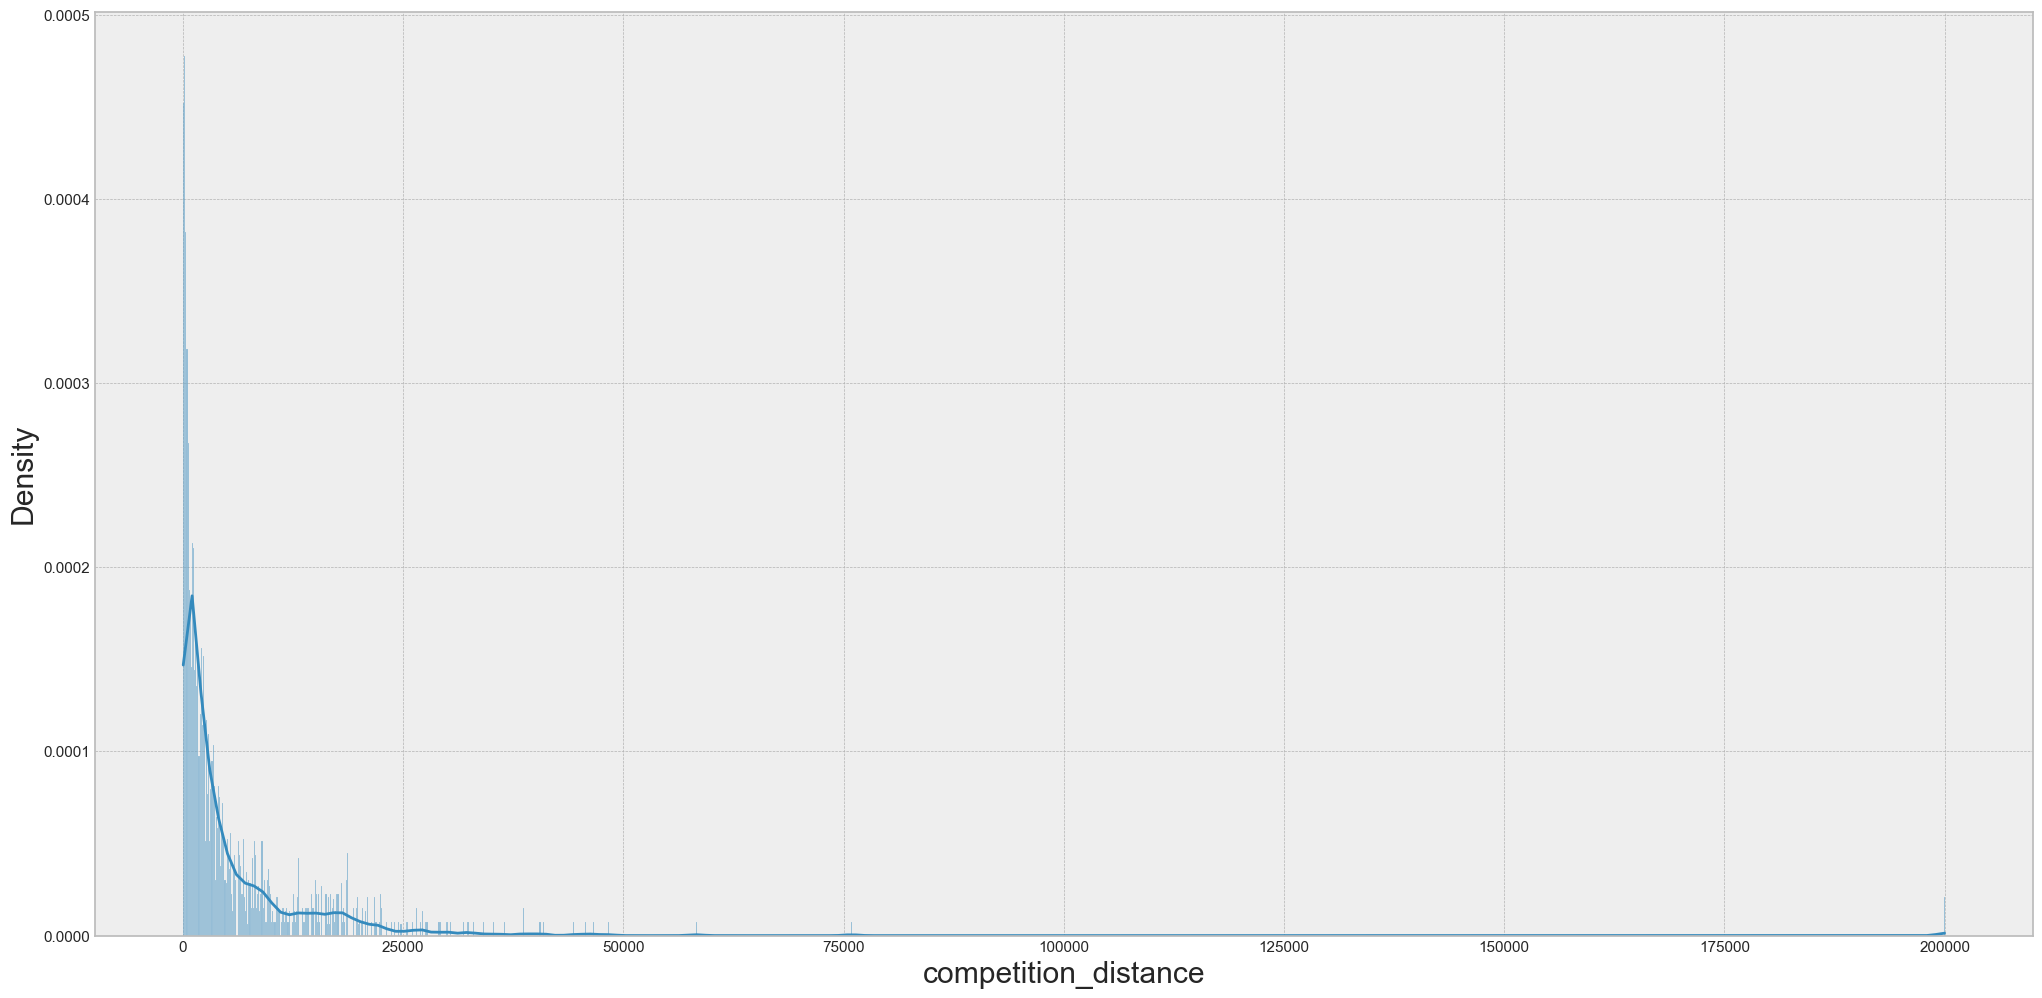

In [18]:
sns.histplot(df1['competition_distance'], kde=True, stat="density")

### 1.7.2 Categoric Atrributes

In [19]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday                    4
store_type                       4
assortment                       3
competition_open_since_month    12
competition_open_since_year     23
promo2_since_week               52
promo2_since_year                7
promo_interval                   4
month_map                       12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

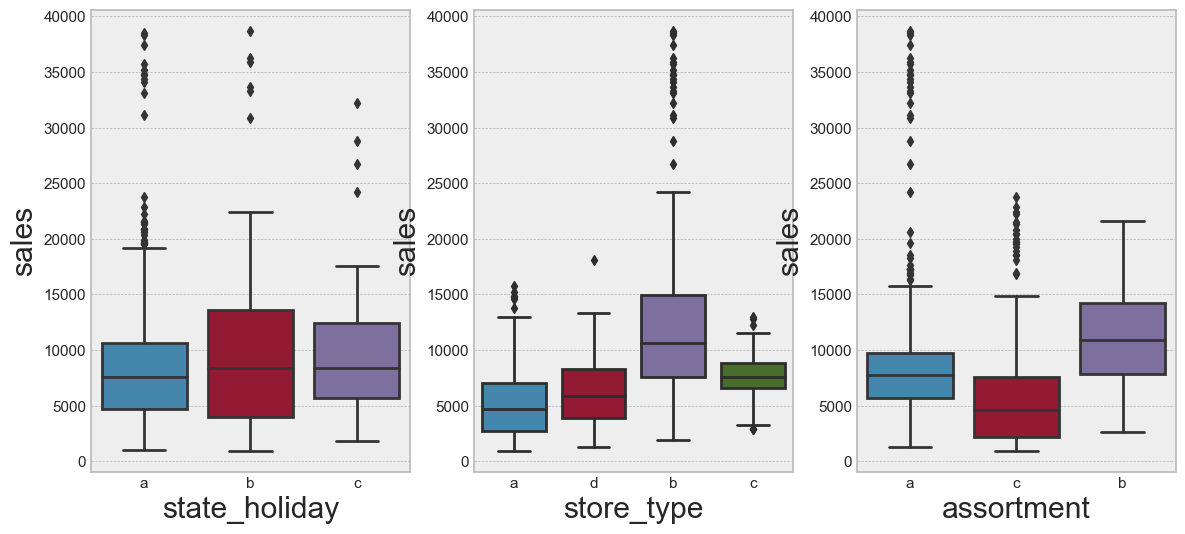

In [20]:
aux1= df1[(df1['state_holiday'] != '0') & (df1['sales']>0)]

plt.figure (figsize = (14,6))
plt.subplot(1,3,1)
sns.boxplot(x='state_holiday',y='sales',data=aux1)
plt.subplot(1,3,2)
sns.boxplot(x='store_type',y='sales',data=aux1)
plt.subplot(1,3,3)
sns.boxplot(x='assortment',y='sales',data=aux1)

# 2.0 Feature Enginnering


In [21]:
df2 = df1.copy()

## 2.1 Mind Map Hypotheses

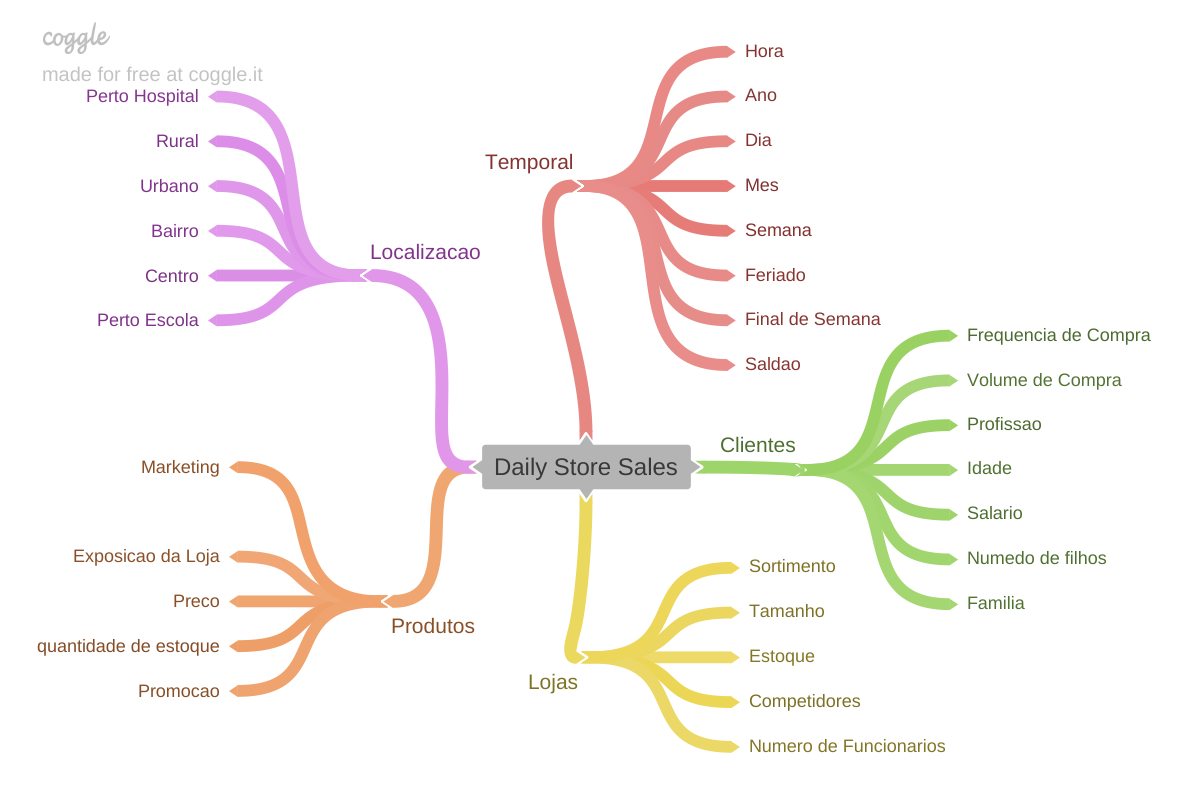

In [22]:
Image('img/mindmaphipoteses.png',width=700, height=100)

## 2.1.1 Store Hypothesis

**1.** Lojas com maior quadro de funcionarios deveriam vender mais.

**2.** Lojas com maior estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com menor porte deveriam vender menos.

**5.** Lojas com maior sortimento deveriam vender mais.

**6.** Lojas com competidores a mais tempo deveriam vender mais.

**7.** Lojas com competidores mais proximos deveriam vender menos.

## 2.1.2 Products Hypothesis 

**1.** Lojas que investe mais em marketing deveriam vender mais.

**2.** Lojas que expoe mais produtos expostos na vitrine deveriam vender mais.

**3.** Lojas que tem precos menores em produtos deveriam vender mais.

**4.** Lojas que tem precos menores por mais tempo deveriam vender mais.

**5.** Lojas com promocoes mais agressivas(desconstos maiores) deveriam vender mais.

**6.** Lojas com promocoes ativas por mais tempo deveriam vender mais.

**7.** Lojas com mais promocoes consecutivas deveriam vender mais.

**8.** Lojas com mais dias de promocoes deveriam vender mais.



## 2.1.2 Time Hypothesis 

**1.** Lojas que tem mais feriados deveriam vender menos.

**2.** Lojas que abrem nos primeiros 6 meses deveriam vender mais.

**3.** Lojas que abrem nos finais de semana deveriam vender mais.

**4.** Lojas que abrem durante o feriado de natal deveriam vender mais.

**5.** Lojas deveriam vender mais a cada ano.

**6.** Lojas deveriam vender mais no segundo semestre do ano.

**7.** Lojas deveriam vender mais depois do dia 10 de cada mes.

**8.** Lojas deveriam vender menos nos finais de semana.

**9.** Lojas deveriam vender menos durante as ferias escolares.





## 2.2 Final List of Hypotheses

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores a mais tempo deveriam vender mais.

**3.** Lojas com competidores mais proximos deveriam vender menos.

**4.** Lojas com promocoes ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais promocoes consecutivas deveriam vender mais.

**6.** Lojas com mais dias de promocoes deveriam vender mais.

**7.** Lojas que abrem no feriado de natal deveriam mais.

**8.** Lojas que tem precos menores em produtos deveriam vender mais.

**9.** Lojas deveriam vender mais ao longo do ano.

**10.** Lojas com promocoes mais agressivas(desconstos maiores) deveriam vender mais.

**11.** Lojas deveriam vender mais após o dia 10 de cada mes.

**12.** Lojas deveriam vender menos nos finais de semana.

**13.** Lojas deveriam vender menos durante o feriado escolar



## 2.3 Feature Enginnering

In [23]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

# 3.0 Variables Filtering

In [24]:
df3 = df2.copy()

## 3.1 Rows Filtering

In [25]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Columns Selection

In [26]:
cols_drop = ['customers', 'open','promo_interval', 'month_map']
df3 = df3.drop(cols_drop,axis=1)


In [27]:
df2['assortment'].value_counts()

basic       537445
extended    471470
extra         8294
Name: assortment, dtype: int64

# 4.0 Exploratory Data Analysis

In [28]:
df4 = df3.copy()

## 4.1 Univariate Analysis


### 4.1.1 Response variable

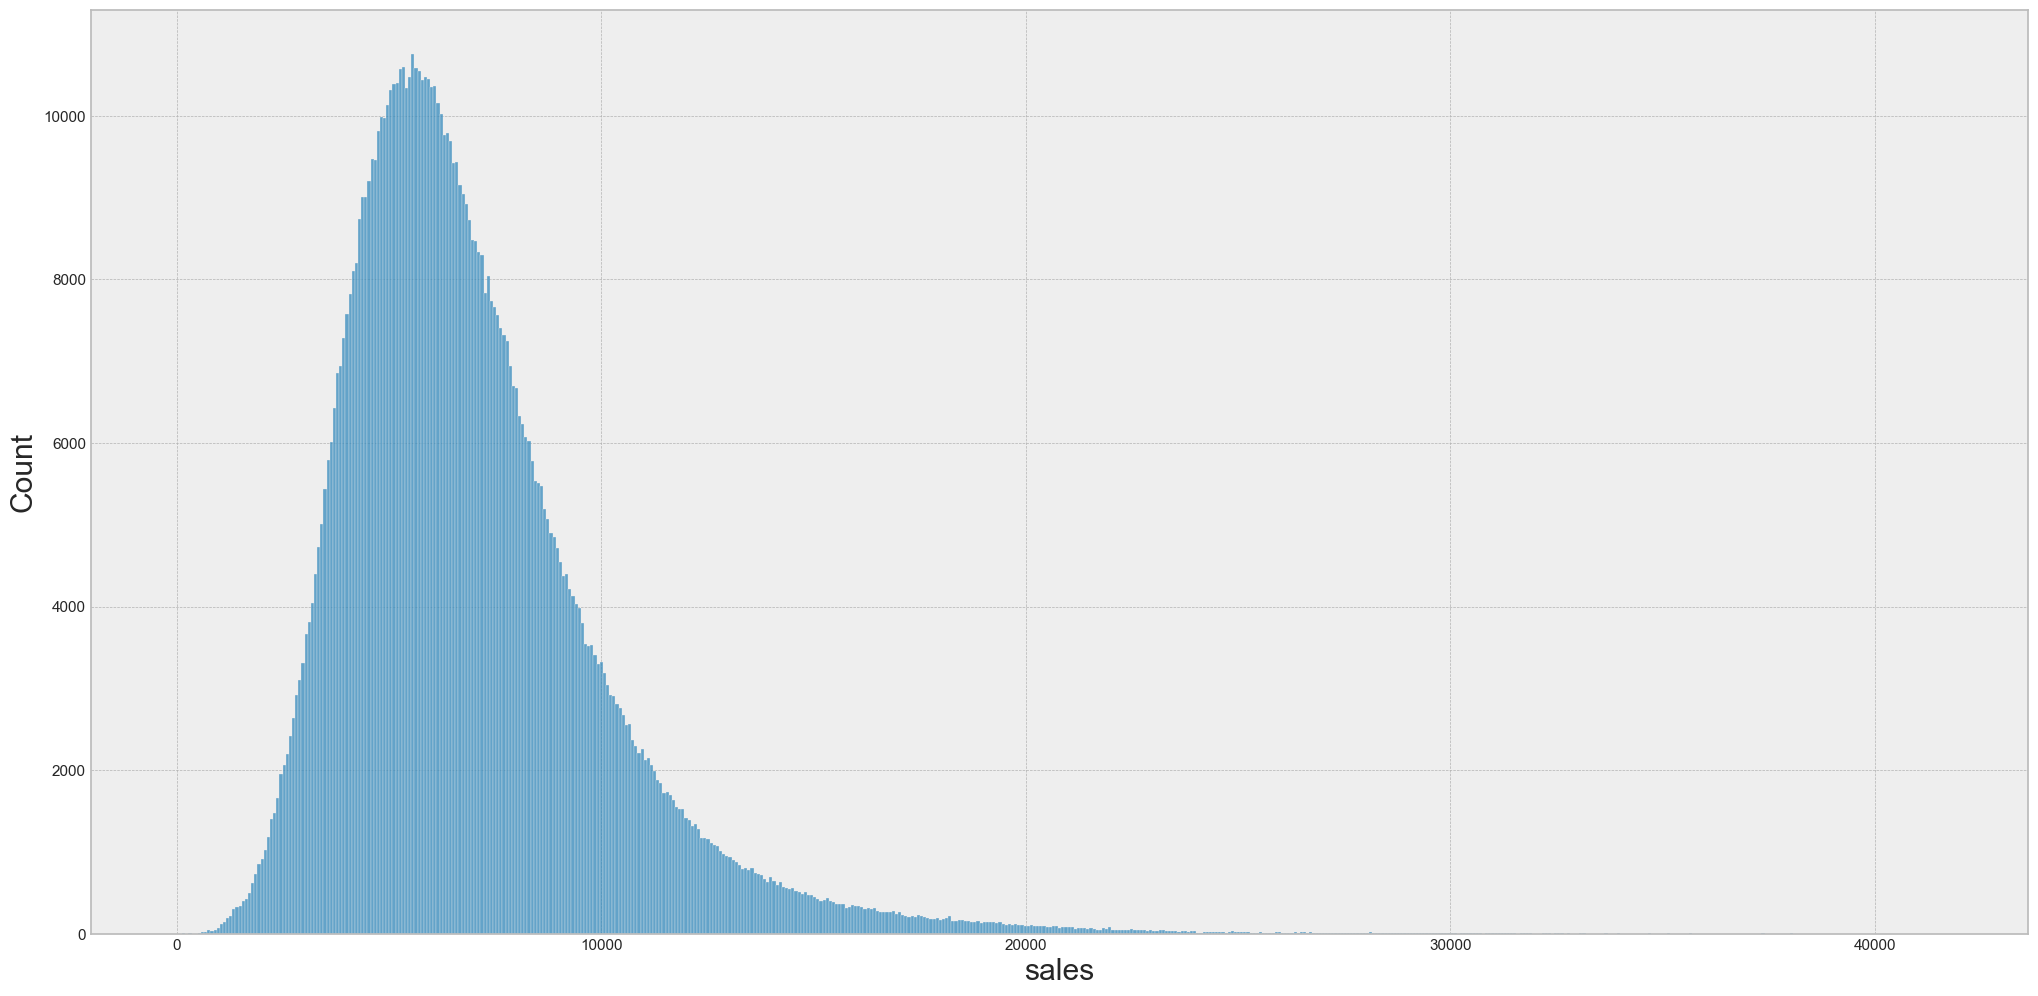

In [29]:
sns.histplot(df4['sales'],kde=False);

### 4.1.2 Numerical variable

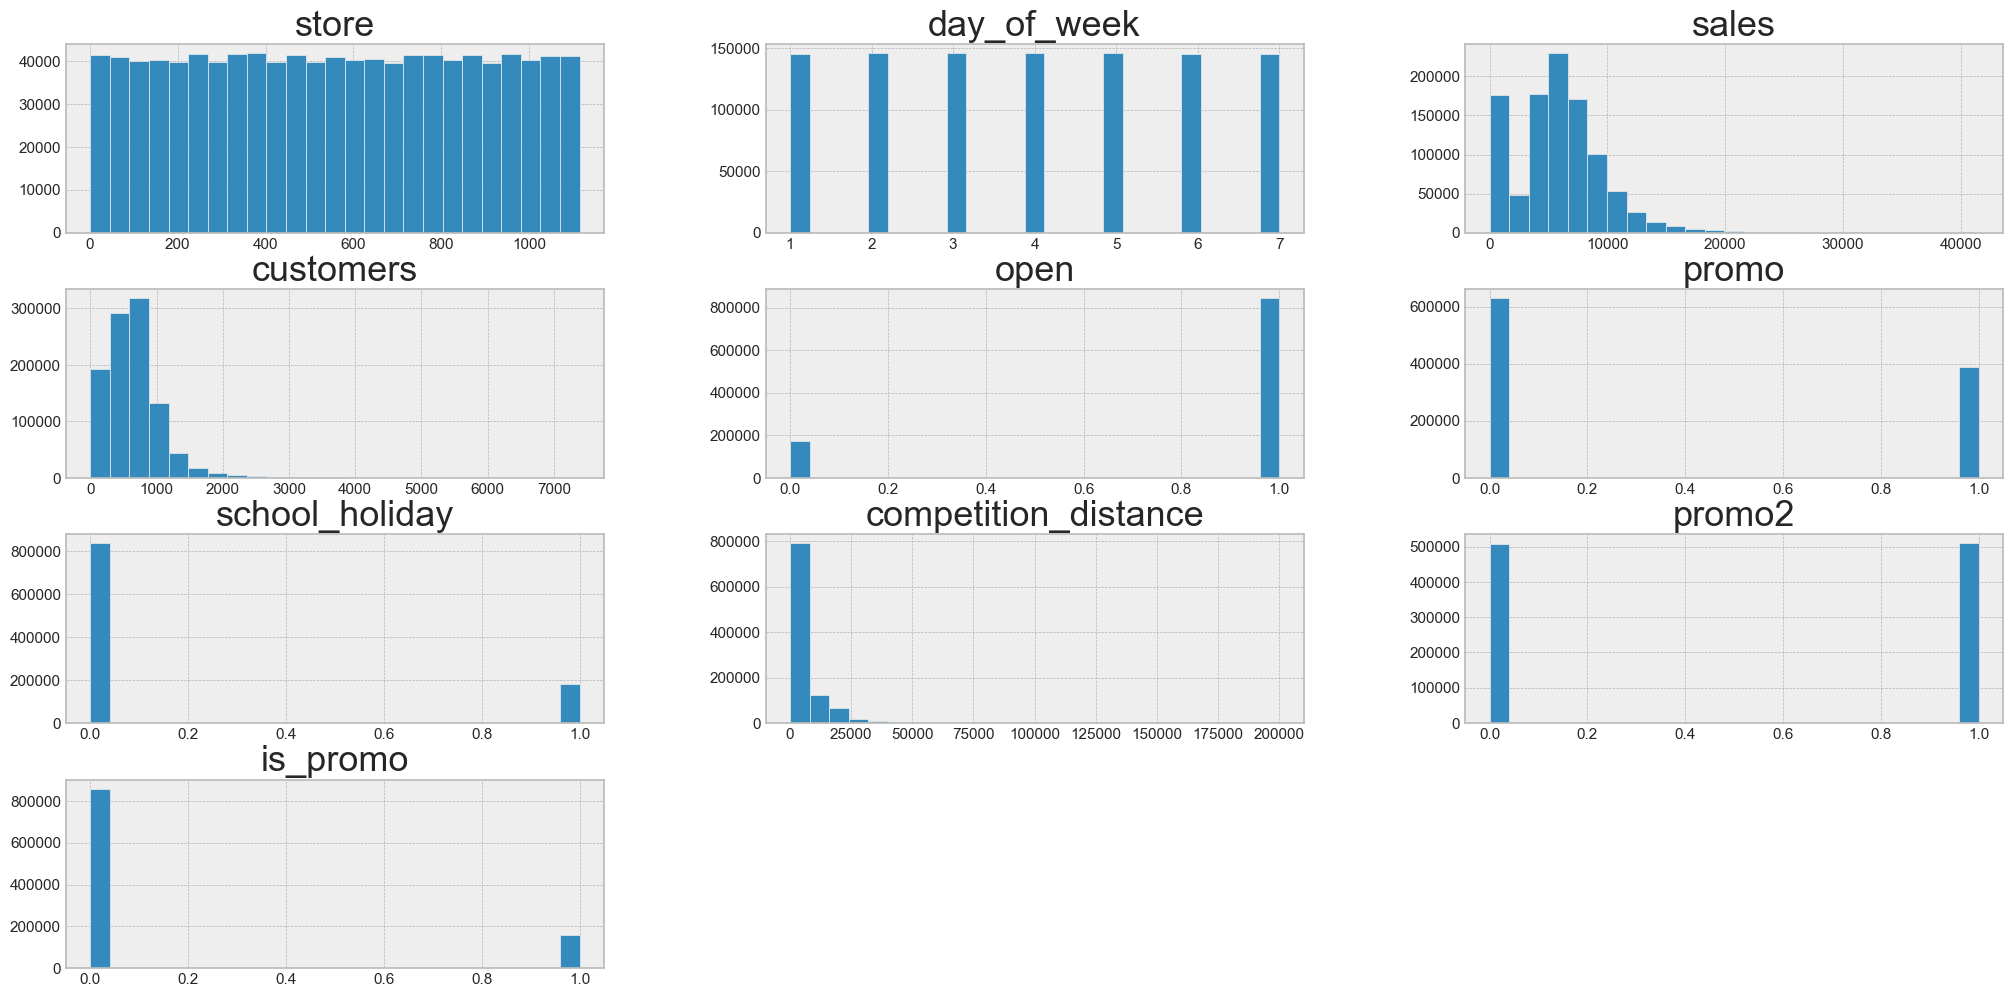

In [30]:
num_attributes.hist(bins= 25);

### 4.1.1 Categorical variable

In [31]:
df4['assortment'].drop_duplicates()


0         basic
3      extended
258       extra
Name: assortment, dtype: object

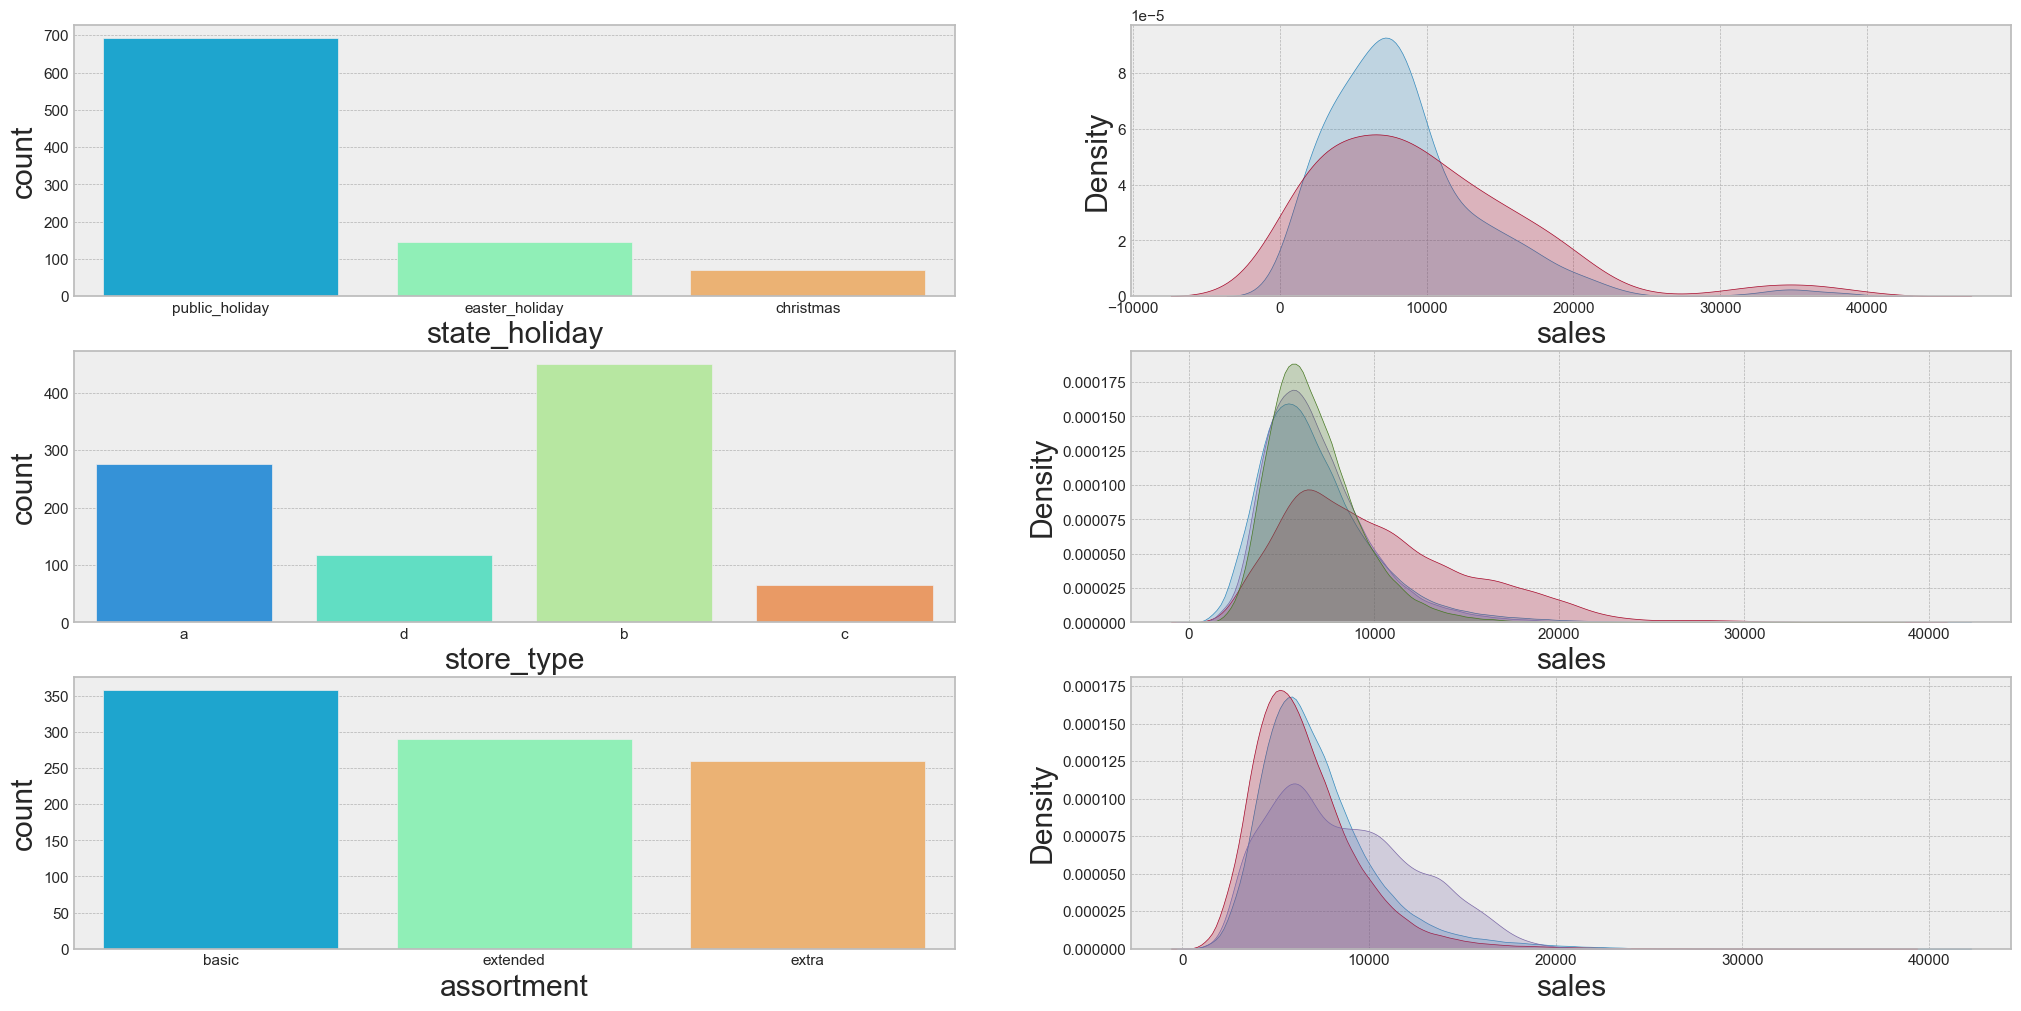

In [32]:
#state holiday
plt.subplot(3,2,1)
a= df4[df4['state_holiday'] != 'regular_day']
sns.countplot(x='state_holiday',data=a, palette='rainbow');
plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday']== 'public_holiday']['sales'],label='public_holiday',fill=True);
sns.kdeplot(df4[df4['state_holiday']== 'easter_holiday']['sales'],label='easter_holiday',fill=True);
sns.kdeplot(df4[df4['state_holiday']== 'christimas']['sales'],label='christimas',fill=True);

# store_type
plt.subplot(3,2,3)
sns.countplot(x='store_type',data=a, palette='rainbow');
plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type']== 'a']['sales'],label='a',fill=True);
sns.kdeplot(df4[df4['store_type']== 'b']['sales'],label='b',fill=True);
sns.kdeplot(df4[df4['store_type']== 'c']['sales'],label='c',fill=True);
sns.kdeplot(df4[df4['store_type']== 'd']['sales'],label='d',fill=True);

# assortments
plt.subplot(3,2,5)
sns.countplot(x='assortment',data=a, palette='rainbow');
plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment']== 'extended']['sales'],label='extended',fill=True);
sns.kdeplot(df4[df4['assortment']== 'basic']['sales'],label='basic',fill=True);
sns.kdeplot(df4[df4['assortment']== 'extra']['sales'],label='extra',fill=True);


## 4.2 Bivariate Analysis


### H**1.** Lojas com maior sortimento deveriam vender mais.
***FALSO** Lojas com MAIOR SORTIMENTOS VENDEM MENOS.

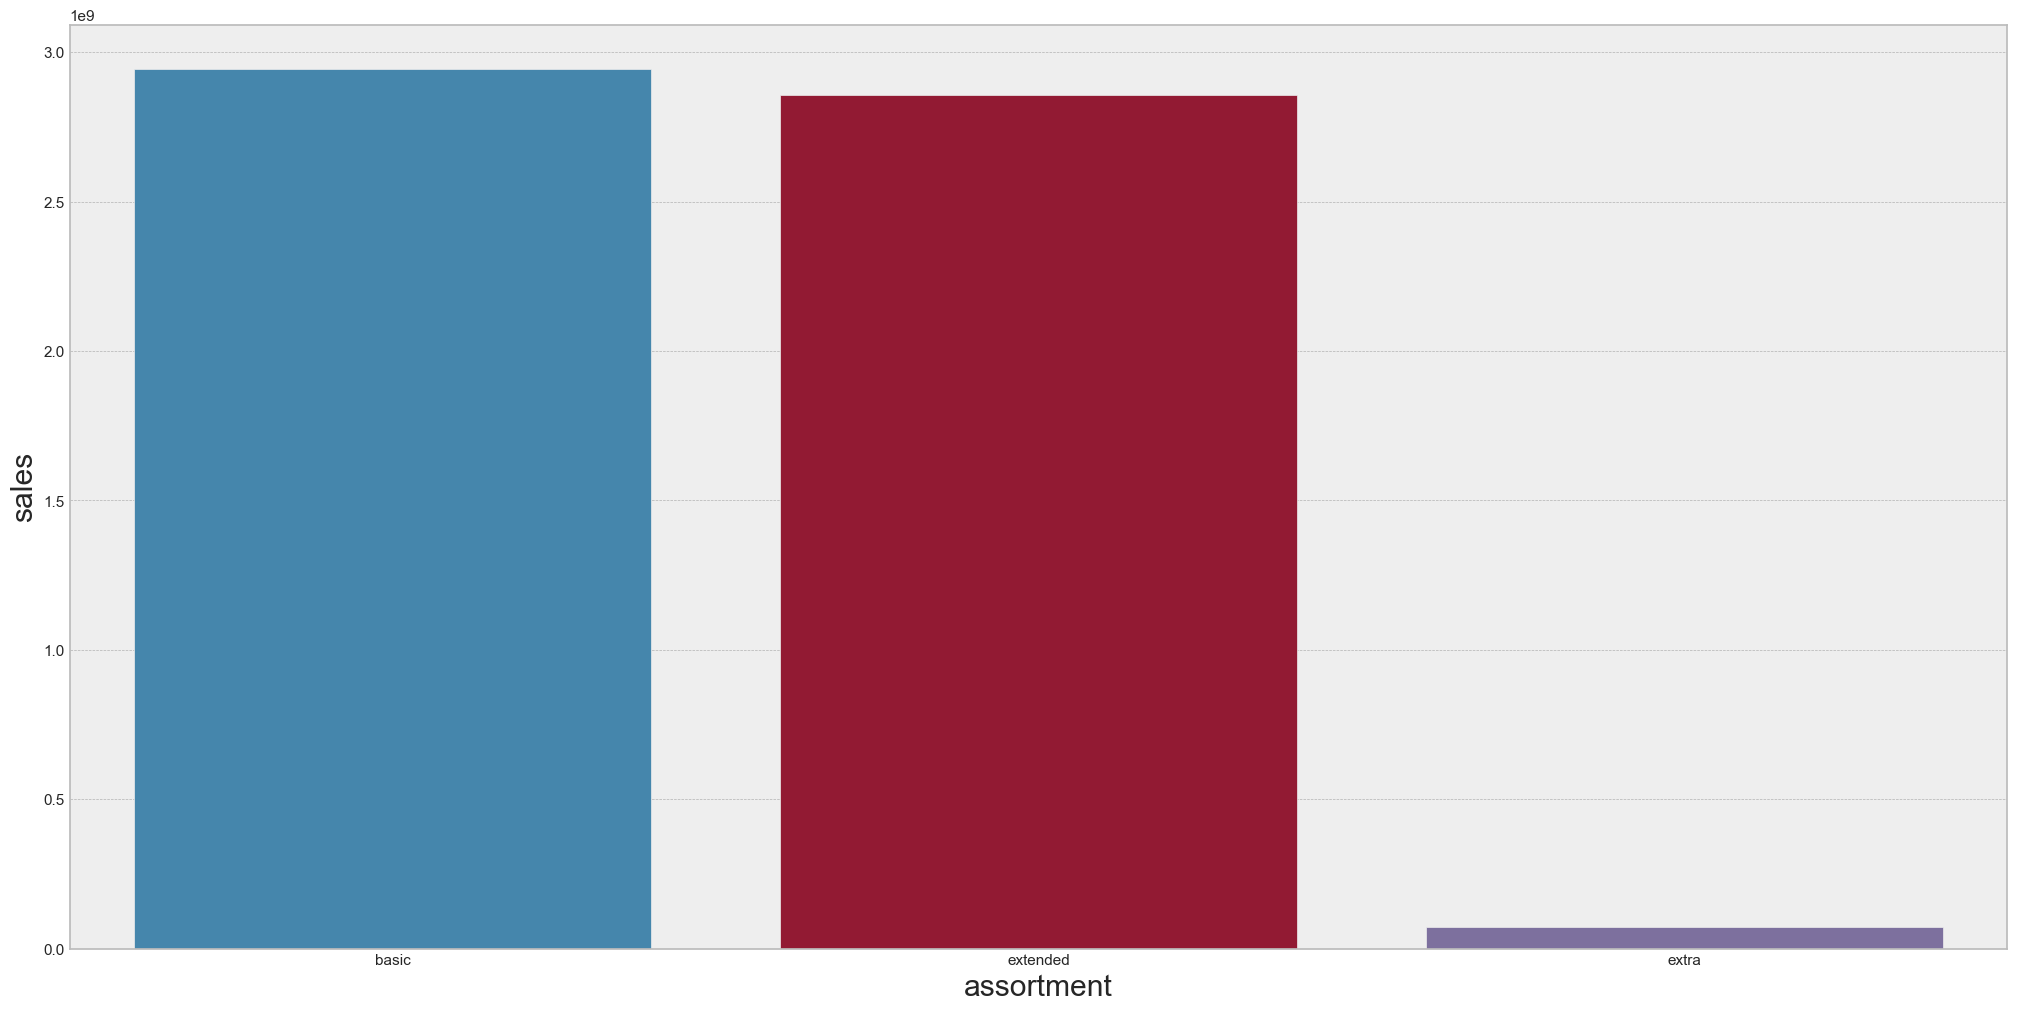

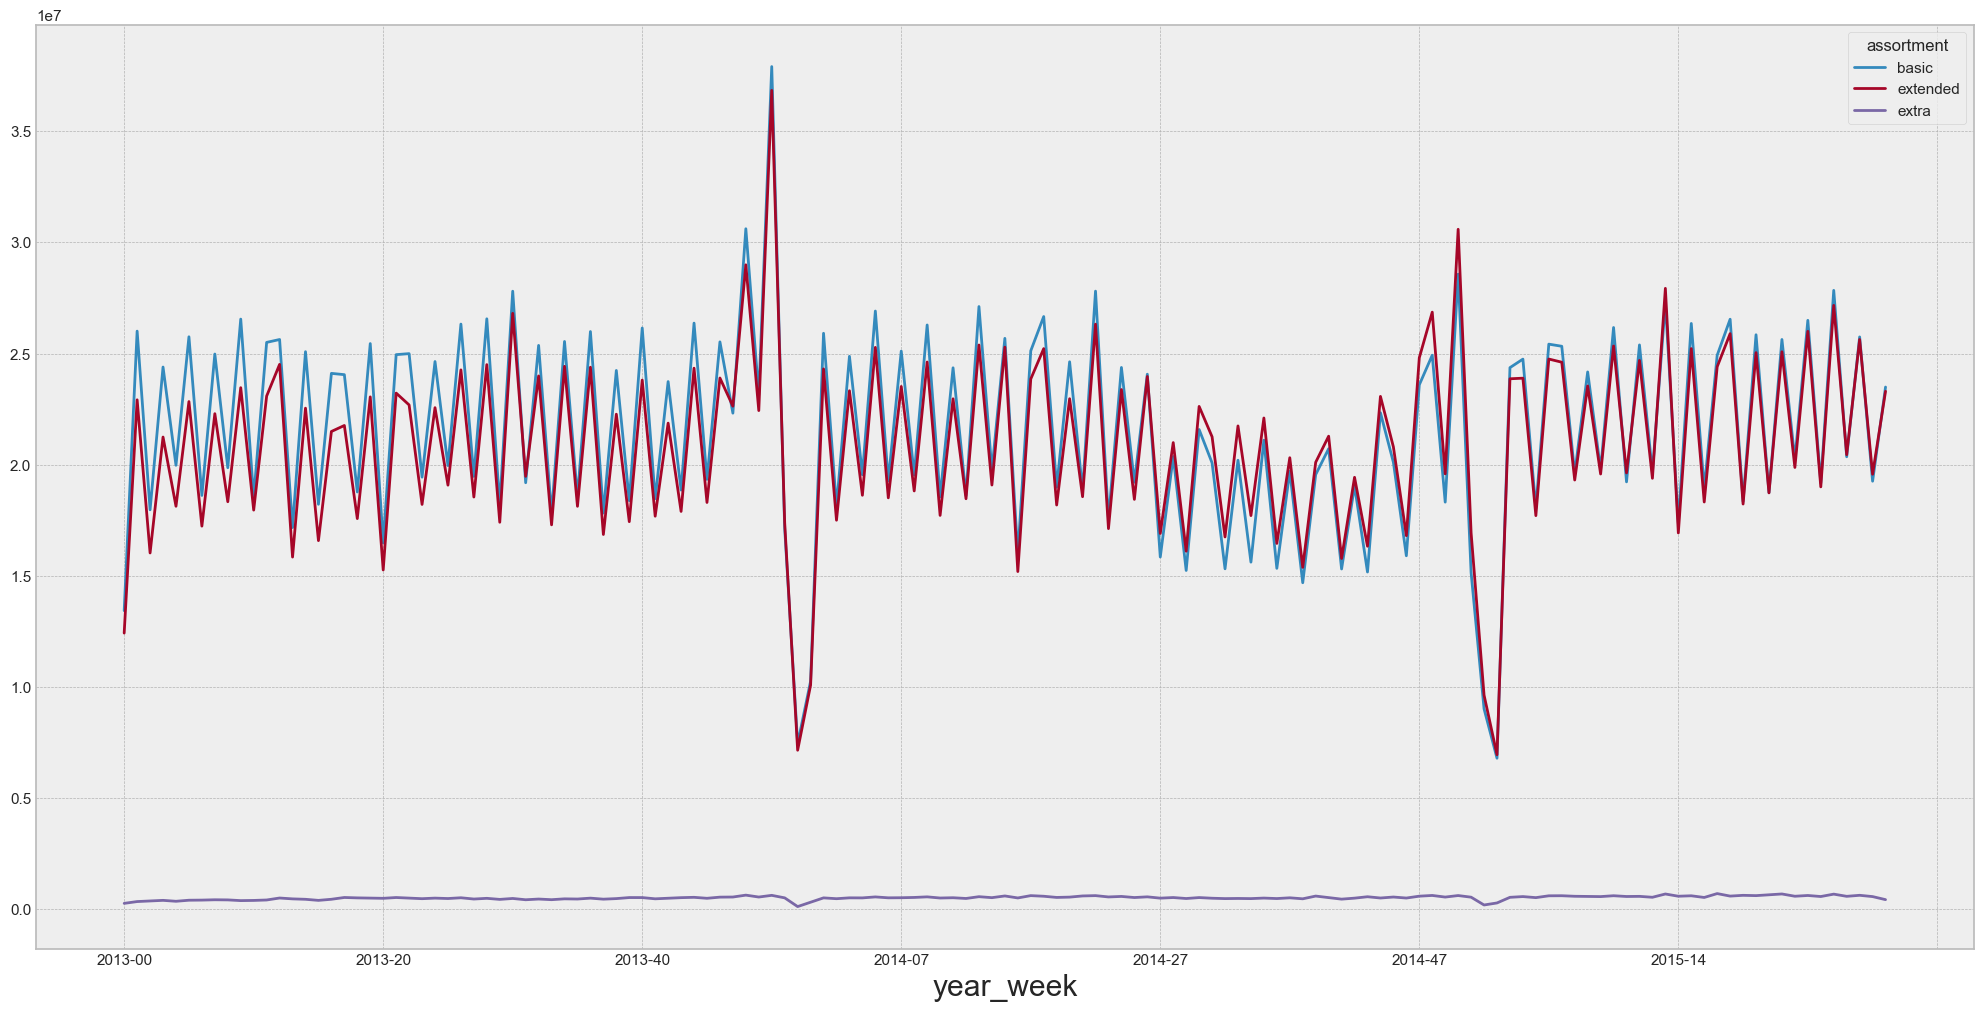

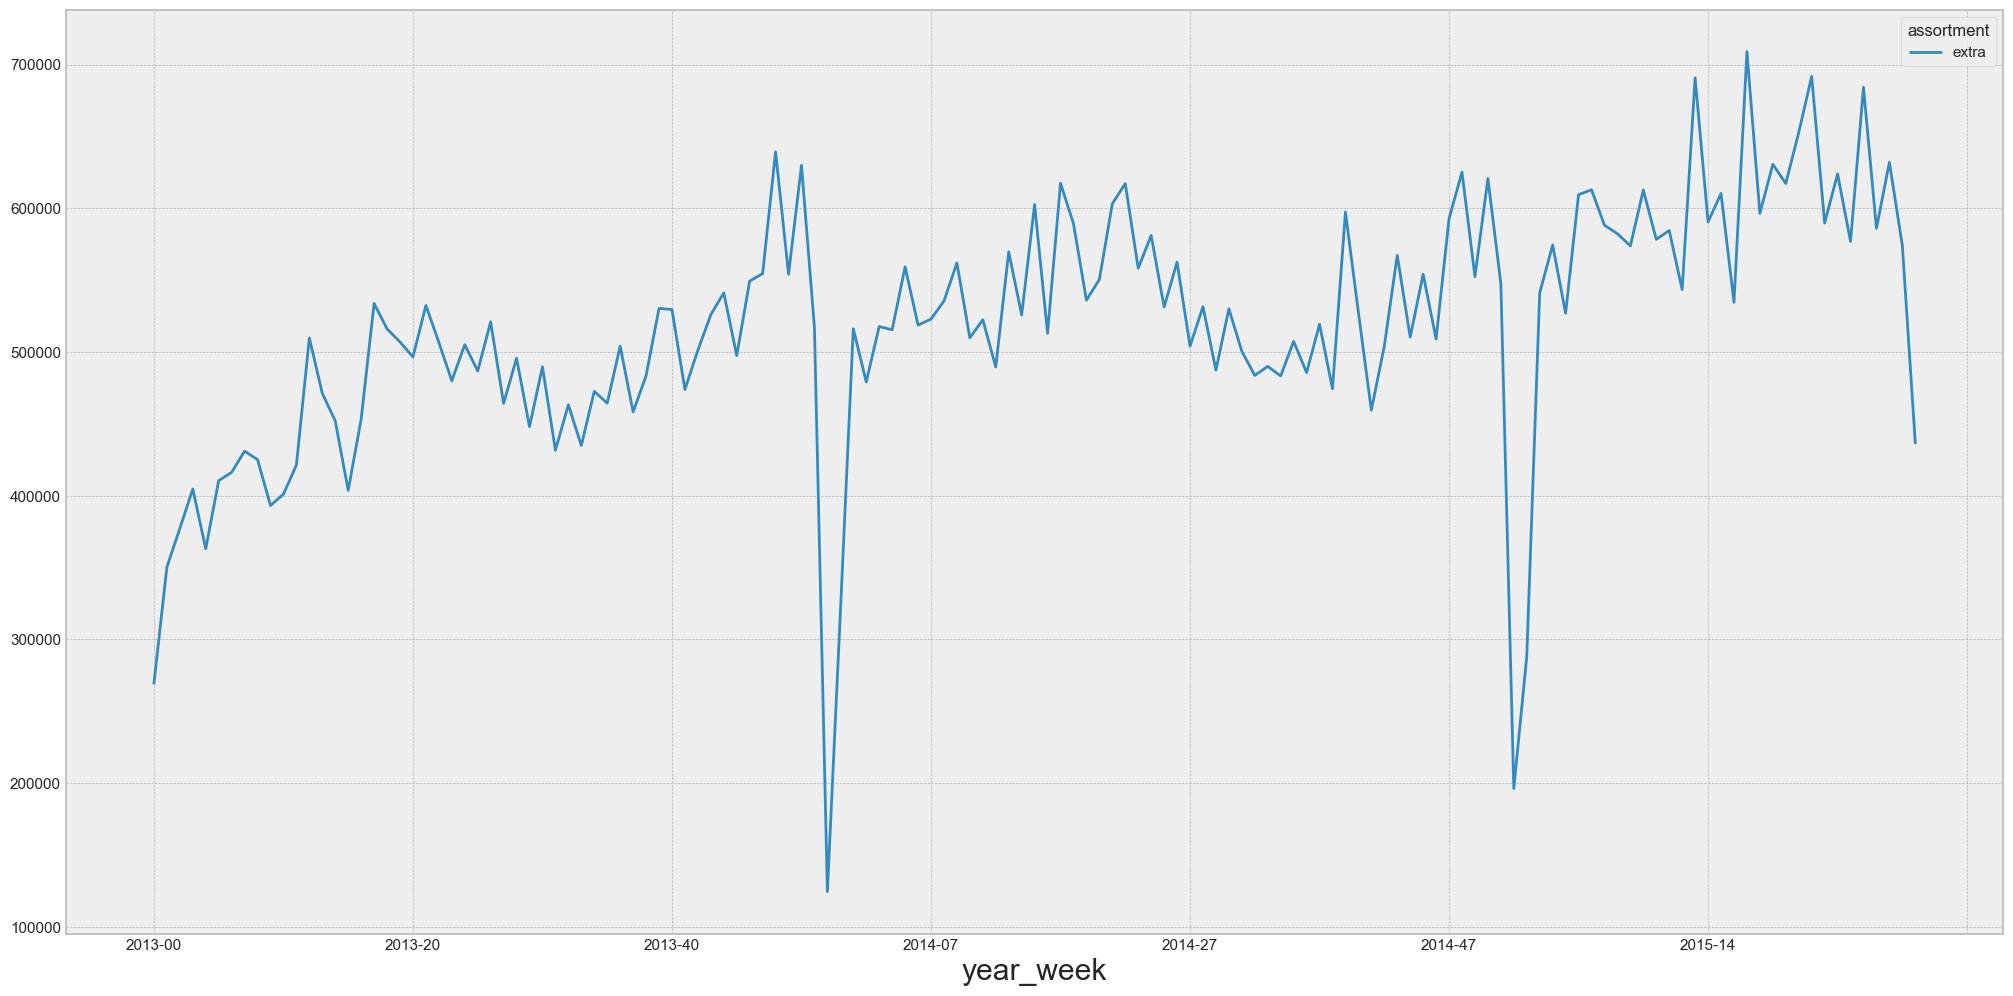

In [33]:
aux1 = df4[['assortment','sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment',y='sales',data= aux1);

aux2 = df4[['year_week','assortment','sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment',values='sales').plot();

aux3 = aux2[aux2['assortment']=='extra']
aux3.pivot(index='year_week', columns='assortment',values='sales').plot();


### H**2.** Lojas com competidores a mais tempo deveriam vender mais.
**FALSO** Lojas com COMPETIDORES COM MAIS TEMPO VENDE MENOS


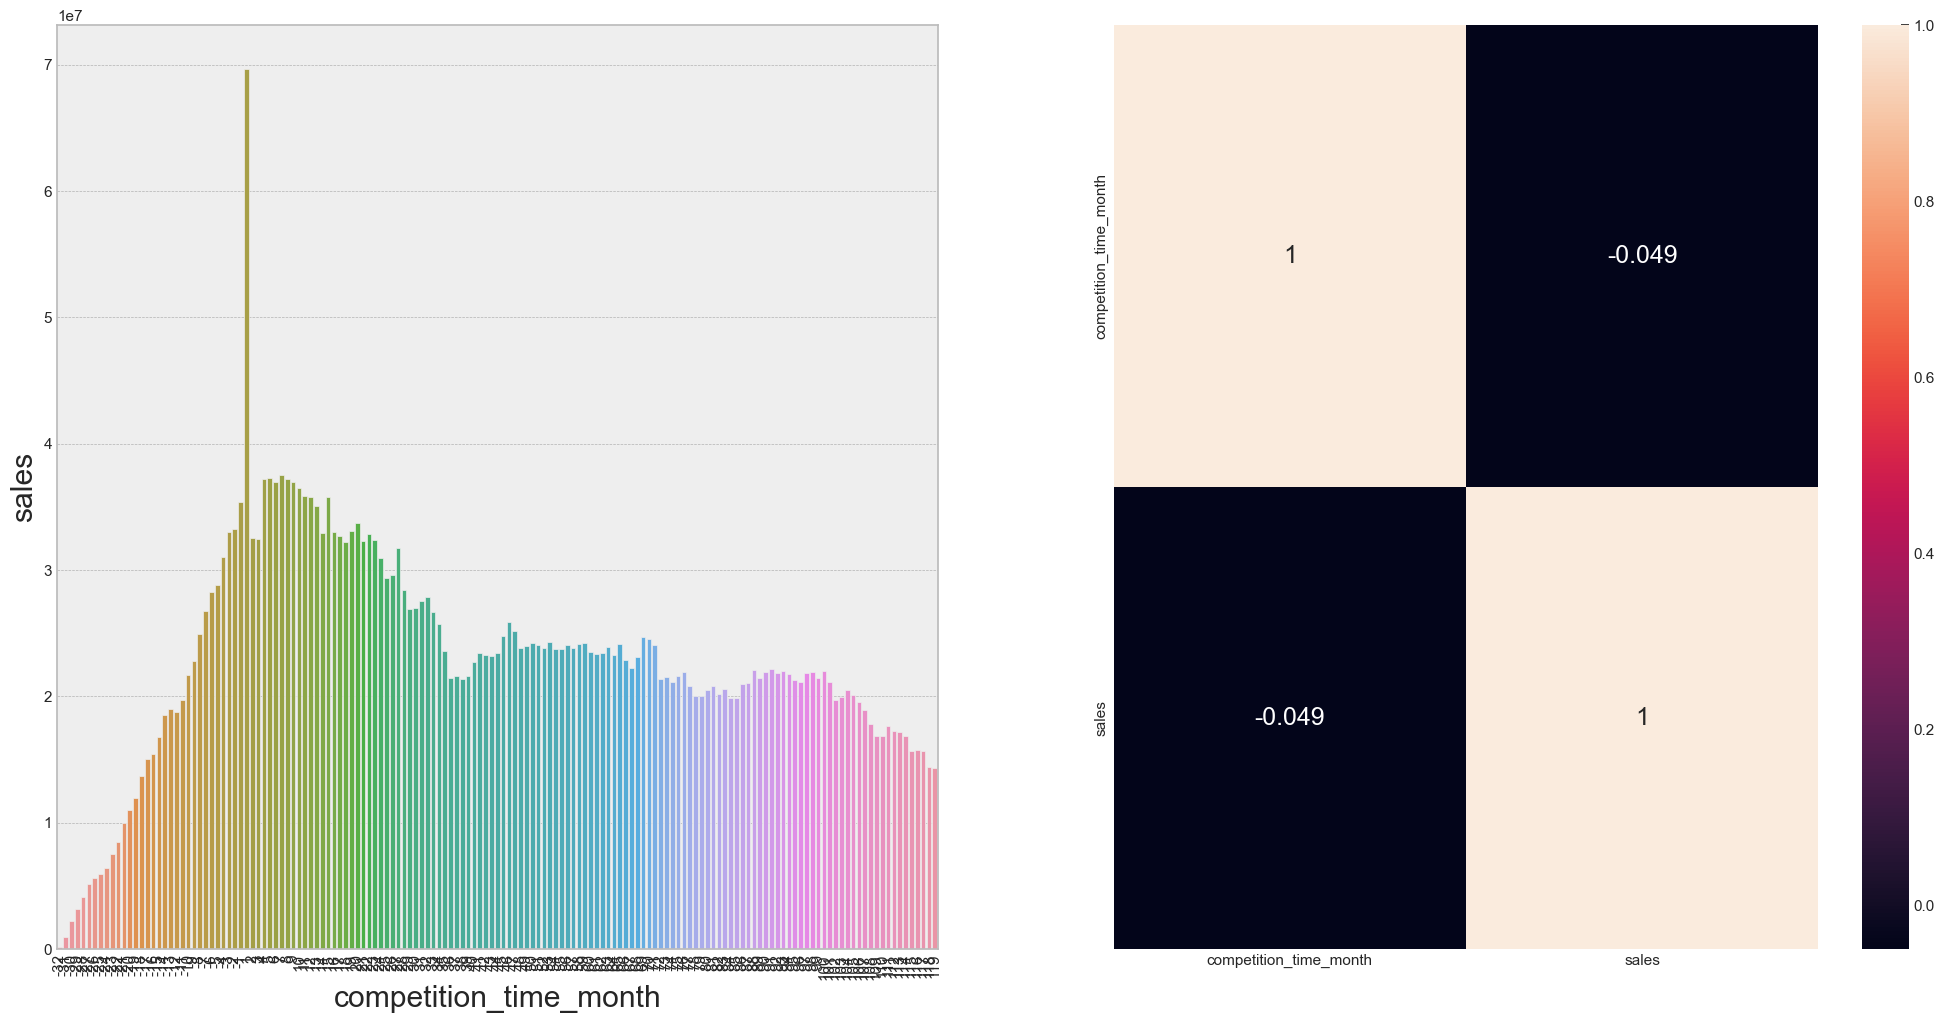

In [34]:
plt.subplot(1,2,1)
aux1= df4[['competition_time_month','sales']].groupby('competition_time_month').sum().reset_index()
aux2= aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] !=0)]
plt.xticks(rotation=90)
sns.barplot(x='competition_time_month',y='sales',data=aux2);

plt.subplot(1,2,2)
sns.heatmap(aux2.corr(method='pearson'),annot=True);


### H**3.** Lojas com competidores mais proximos deveriam vender menos.
**FALSO** Lojas com COMPETIDORES MAIS PROXIMOS VENDEM MAIS.

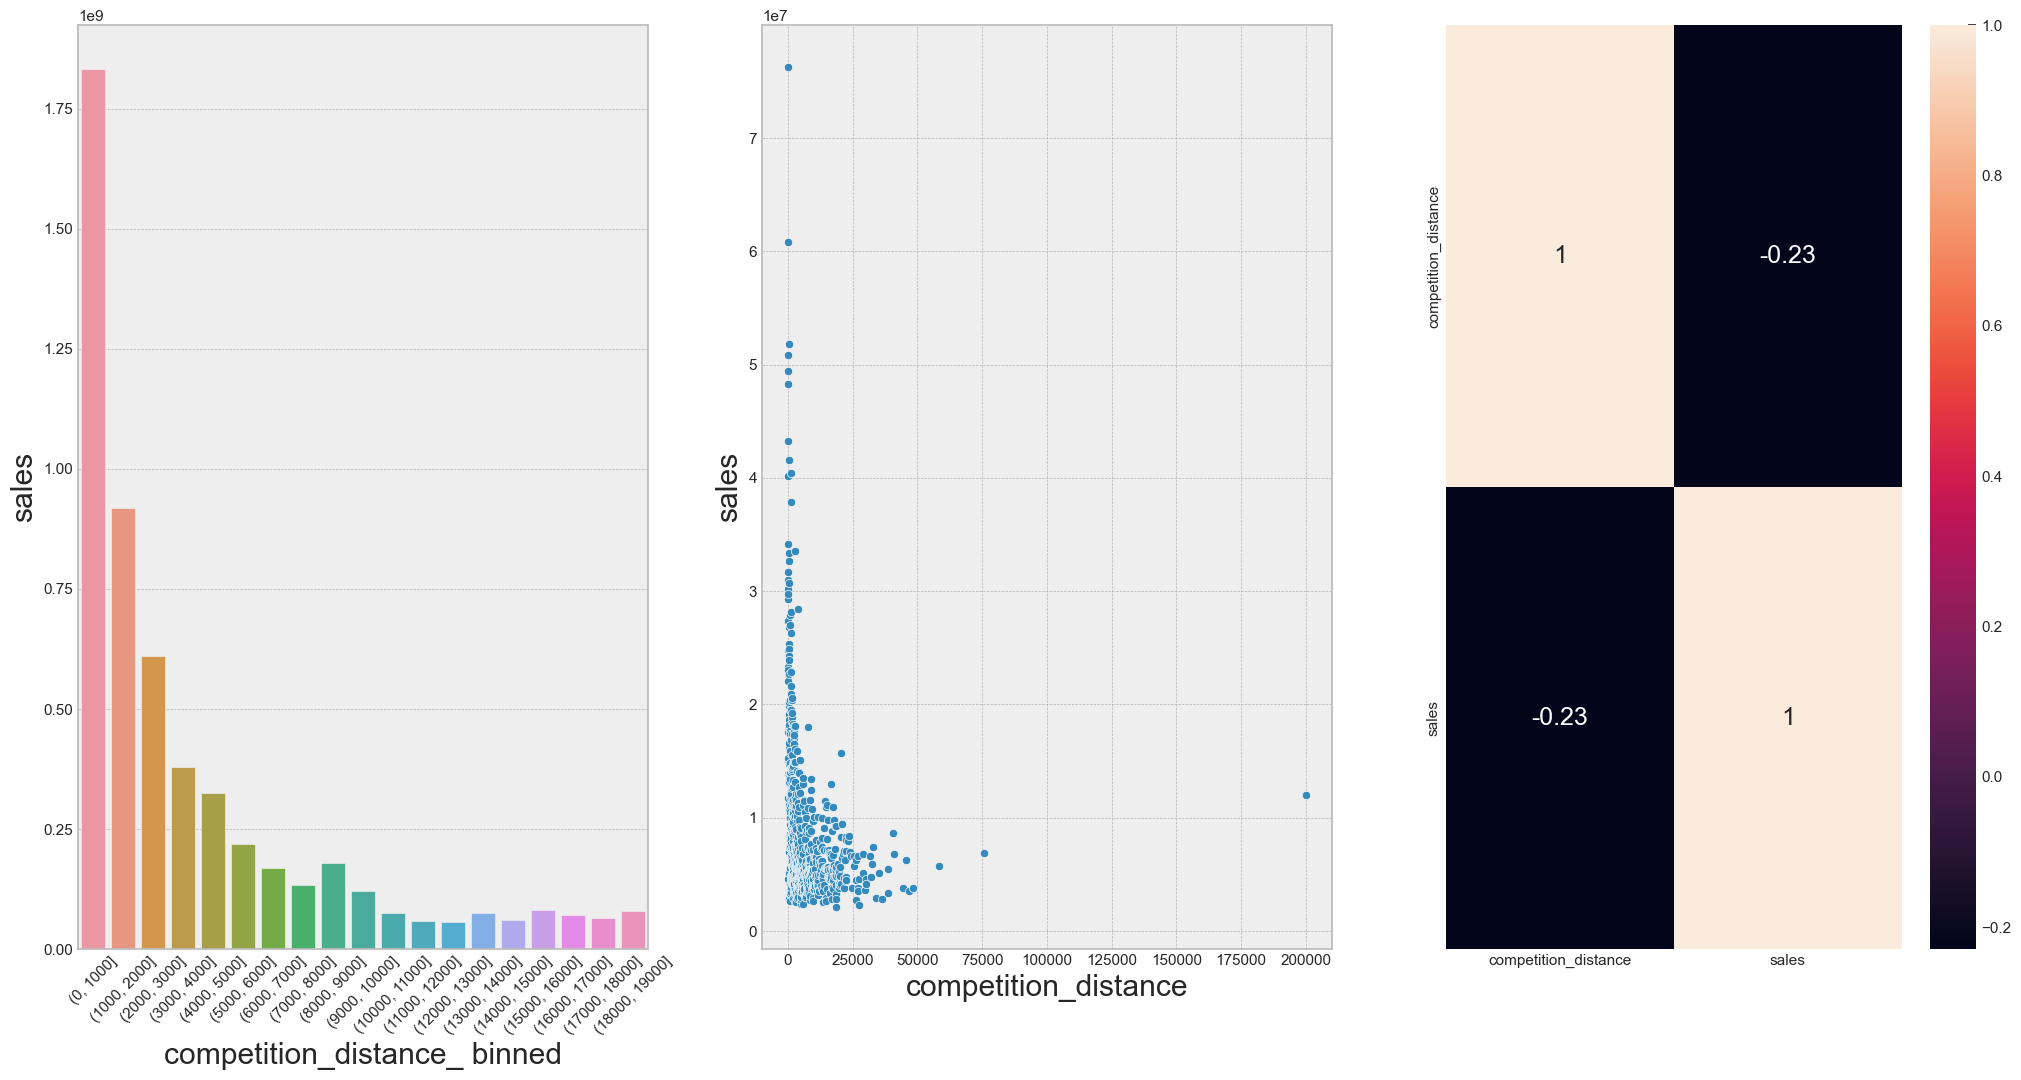

In [35]:
aux1=df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()

#criando grupos para melhorar a visualização da plotagem com barplot:

plt.subplot(1,3,1)
bins=list(np.arange(0,20000,1000))

aux1['competition_distance_ binned'] = pd.cut(aux1['competition_distance'],bins=bins)

aux2= aux1[['competition_distance_ binned','sales']].groupby('competition_distance_ binned').sum().reset_index()
plt.xticks(rotation=45)
sns.barplot(x='competition_distance_ binned',y='sales',data=aux2);

# uma outra opção para dados com muita granularidade é fazer plot de distribuição:
plt.subplot(1,3,2)

sns.scatterplot(x='competition_distance',y='sales',data=aux1)

# consultando o impacto de correlação entre as variaveis
#quanto mais próximo de 1 ou -1 mais forte é a relação
plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True);


### H**4.** Lojas com promocoes ativas por mais tempo deveriam vender mais.
**FALSO** lojas com PROMO ATIVA POR MAIS TEMPO VENDE MENOS


<AxesSubplot:>

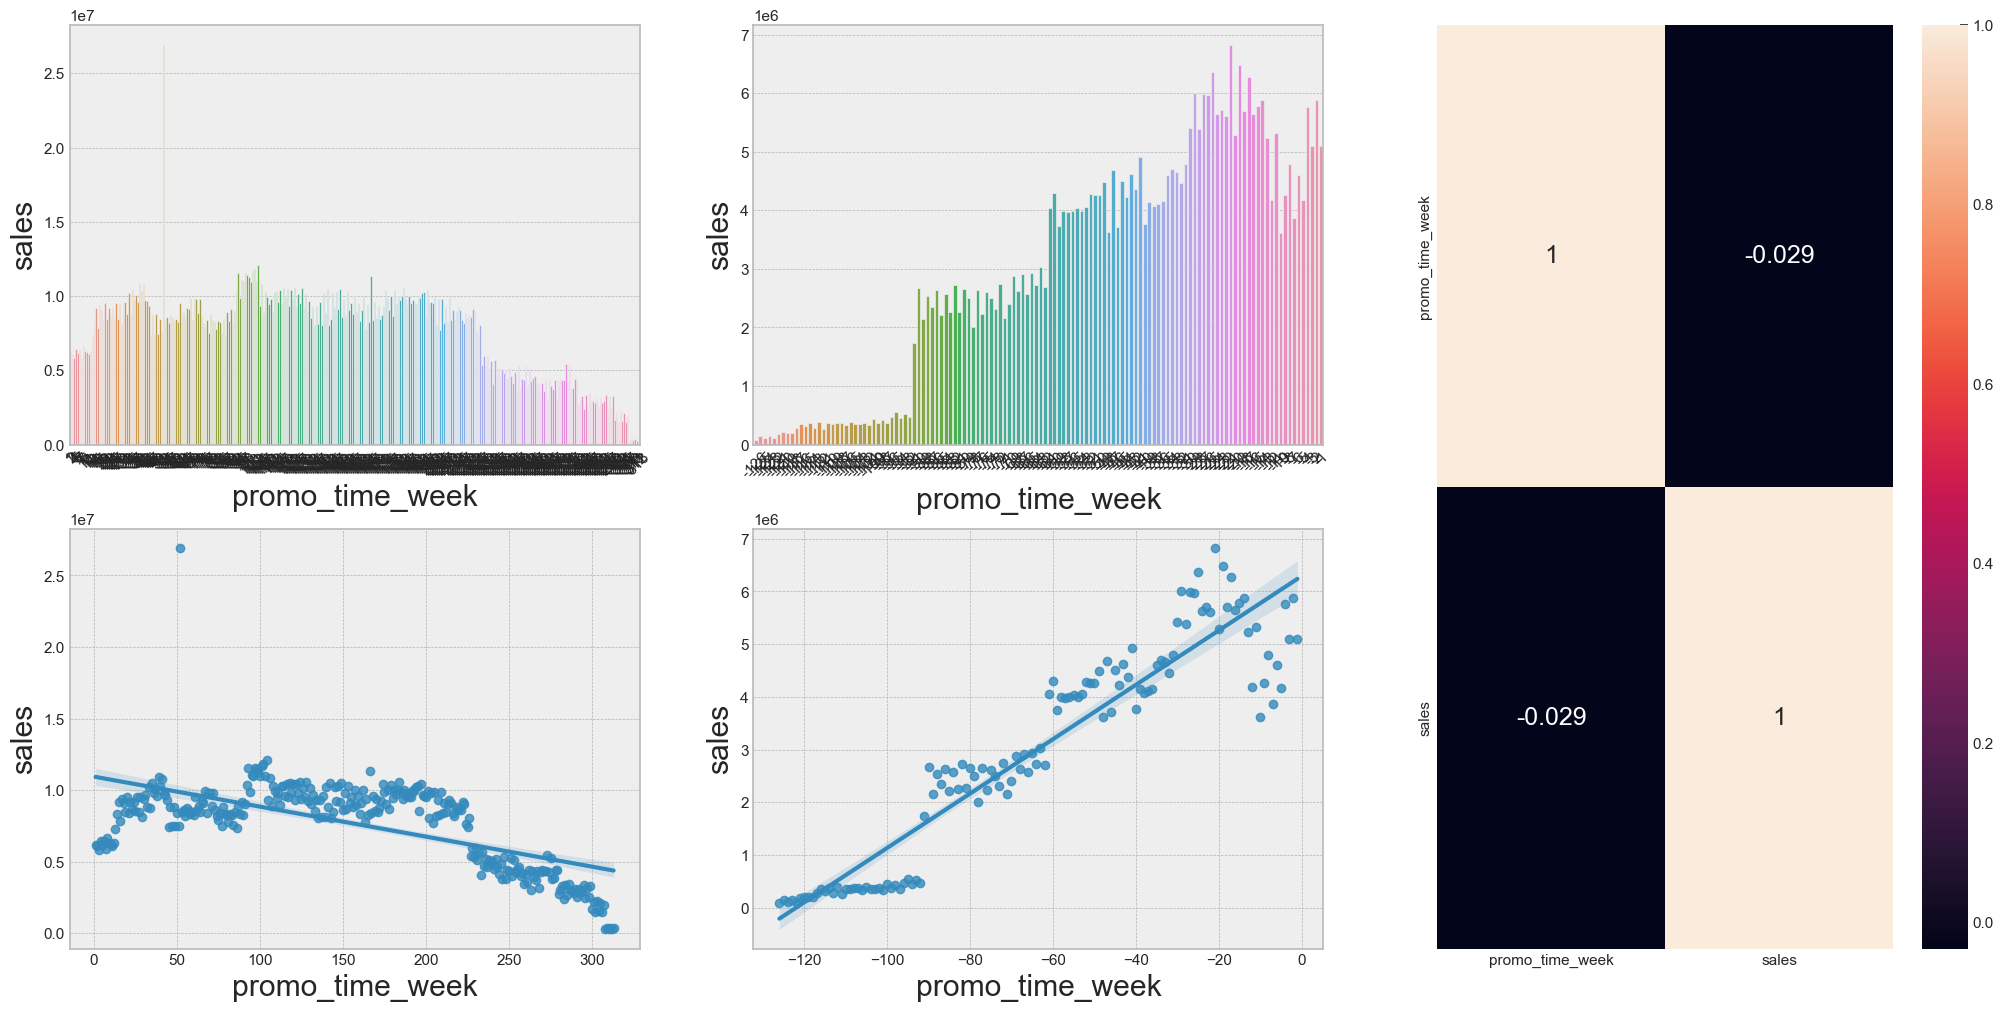

In [36]:
aux1=df4[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()
sns.barplot(x='promo_time_week',y='sales',data=aux1);

grid = GridSpec(2,3)

plt.subplot(grid[0,0])
aux2=aux1[aux1['promo_time_week'] >0] #promo extend
plt.xticks(rotation=45)
sns.barplot(x='promo_time_week',y='sales',data=aux2);

plt.subplot(grid[0,1])
aux3=aux1[aux1['promo_time_week'] <0] #promo regular
plt.xticks(rotation=45)
sns.barplot(x='promo_time_week',y='sales',data=aux3);

plt.subplot(grid[1,0])
sns.regplot(x='promo_time_week',y='sales',data=aux2);


plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week',y='sales',data=aux3);

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'),annot=True)

### <s>H**5.** Lojas com mais promocoes consecutivas deveriam vender mais.</s>



### H**6.** Lojas com mais dias de promocoes deveriam vender mais.
**FALSO** Lojas com MAIS DIAS de PROMOCOES VENDE MENOS.

In [37]:
df4[['promo','promo2','sales']].groupby(['promo','promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


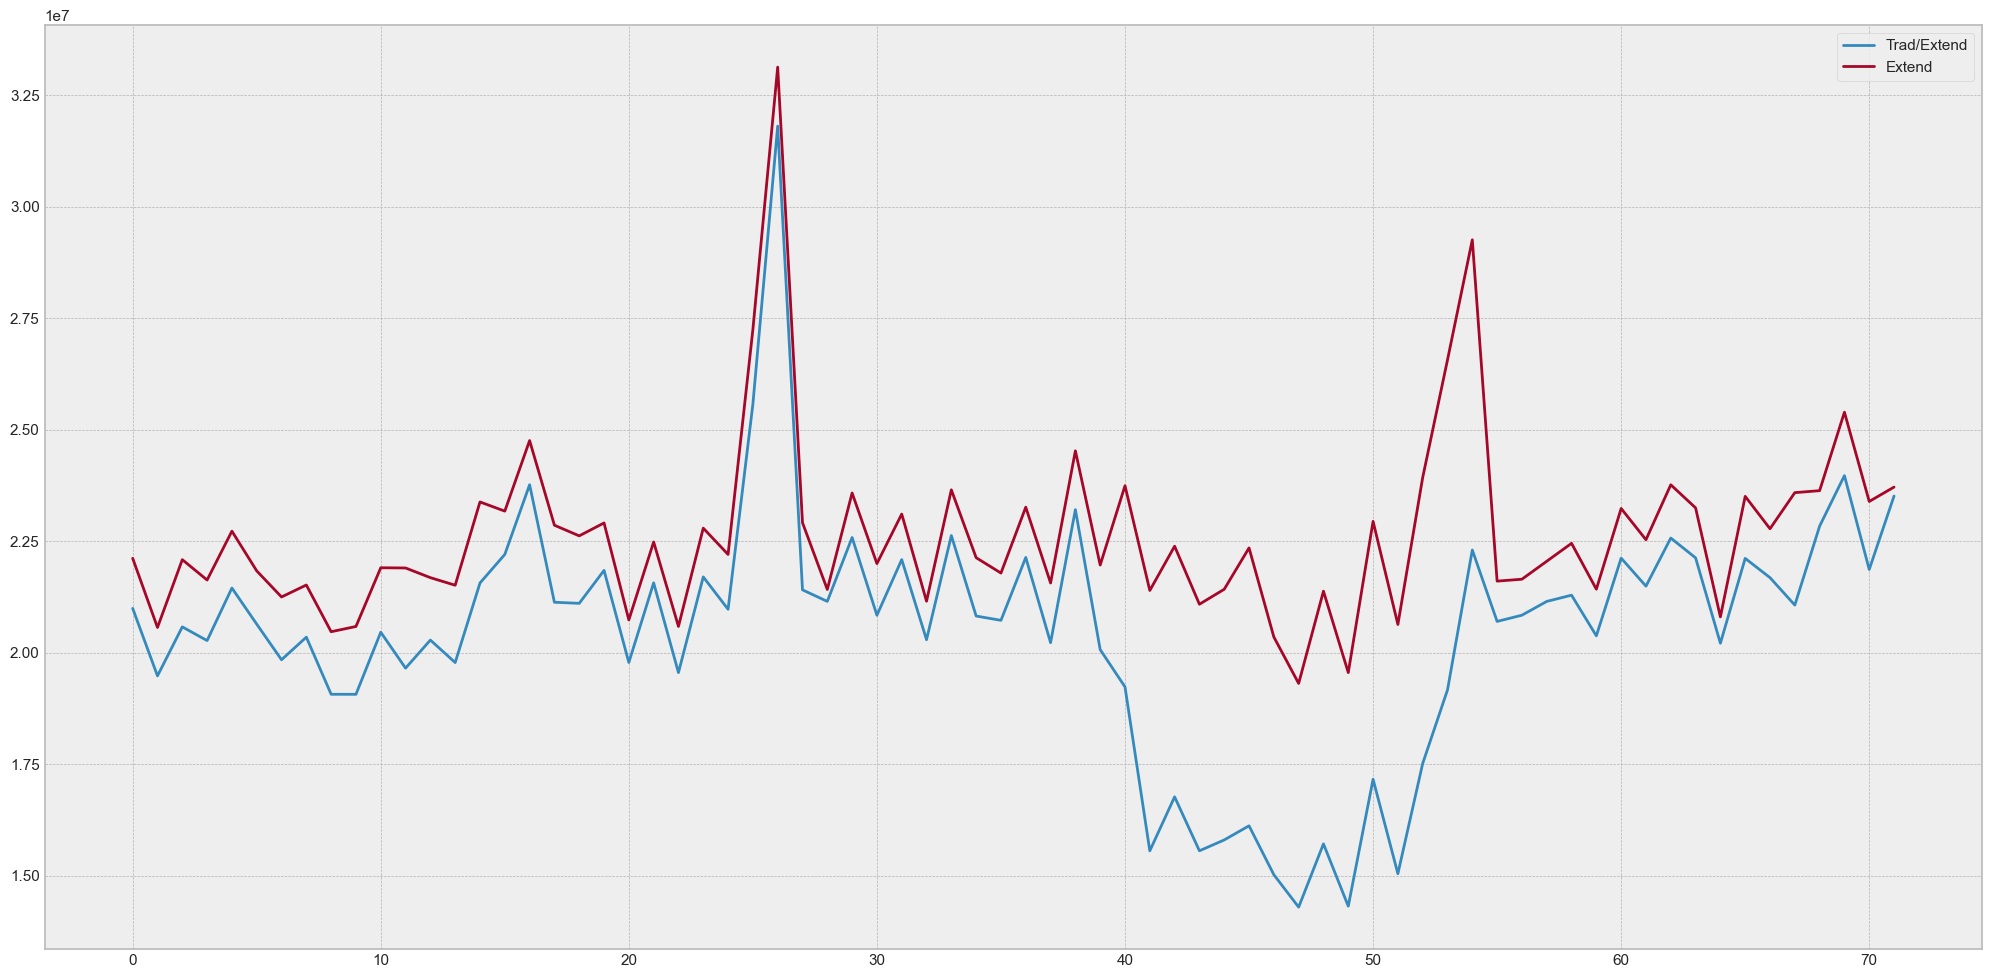

In [38]:
aux1= df4[(df4['promo']==1) & (df4['promo2']==1)][['year_week','sales']].groupby('year_week').sum().reset_index()
aux = aux1.plot()

aux2= df4[(df4['promo']==1) & (df4['promo2']==0)][['year_week','sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=aux);
aux.legend(labels= ['Trad/Extend','Extend']);

### H**7.** Lojas que abrem no feriado de natal deveriam mais.
**FALSO** Lojas que ABREM no NATAL VENDE MENOS.



<AxesSubplot:xlabel='year', ylabel='sales'>

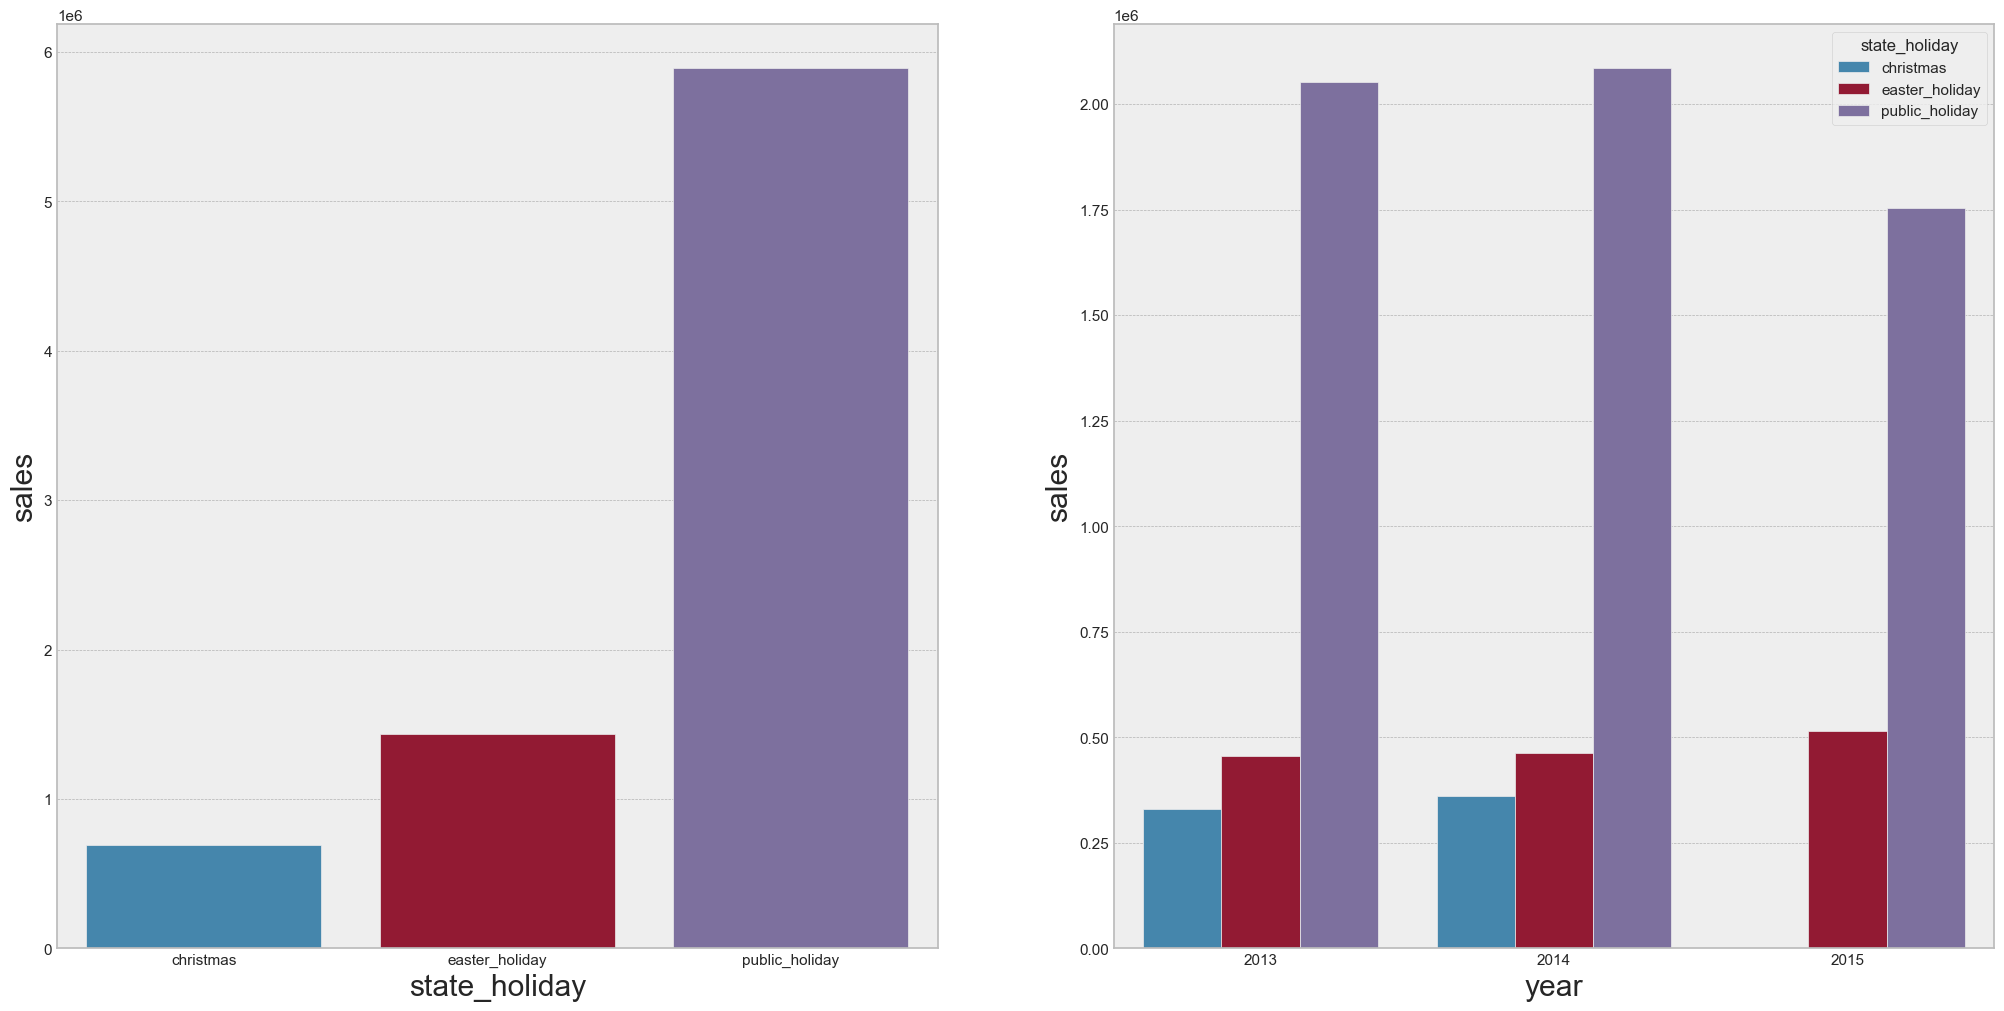

In [39]:
aux=df4[df4['state_holiday']!='regular_day']

plt.subplot(1,2,1)
aux1=aux[['state_holiday','sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday',y='sales',data=aux1)

plt.subplot(1,2,2)
aux2=aux[['year','state_holiday','sales']].groupby(['year','state_holiday']).sum().reset_index()
sns.barplot(x='year',y='sales',hue='state_holiday',data=aux2)



In [40]:
df4.head(2)

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279


### H**9.** Lojas deveriam vender mais ao longo do ano.
**FALSO** Lojas VENDEM MENOS ao LONGO do ANO.


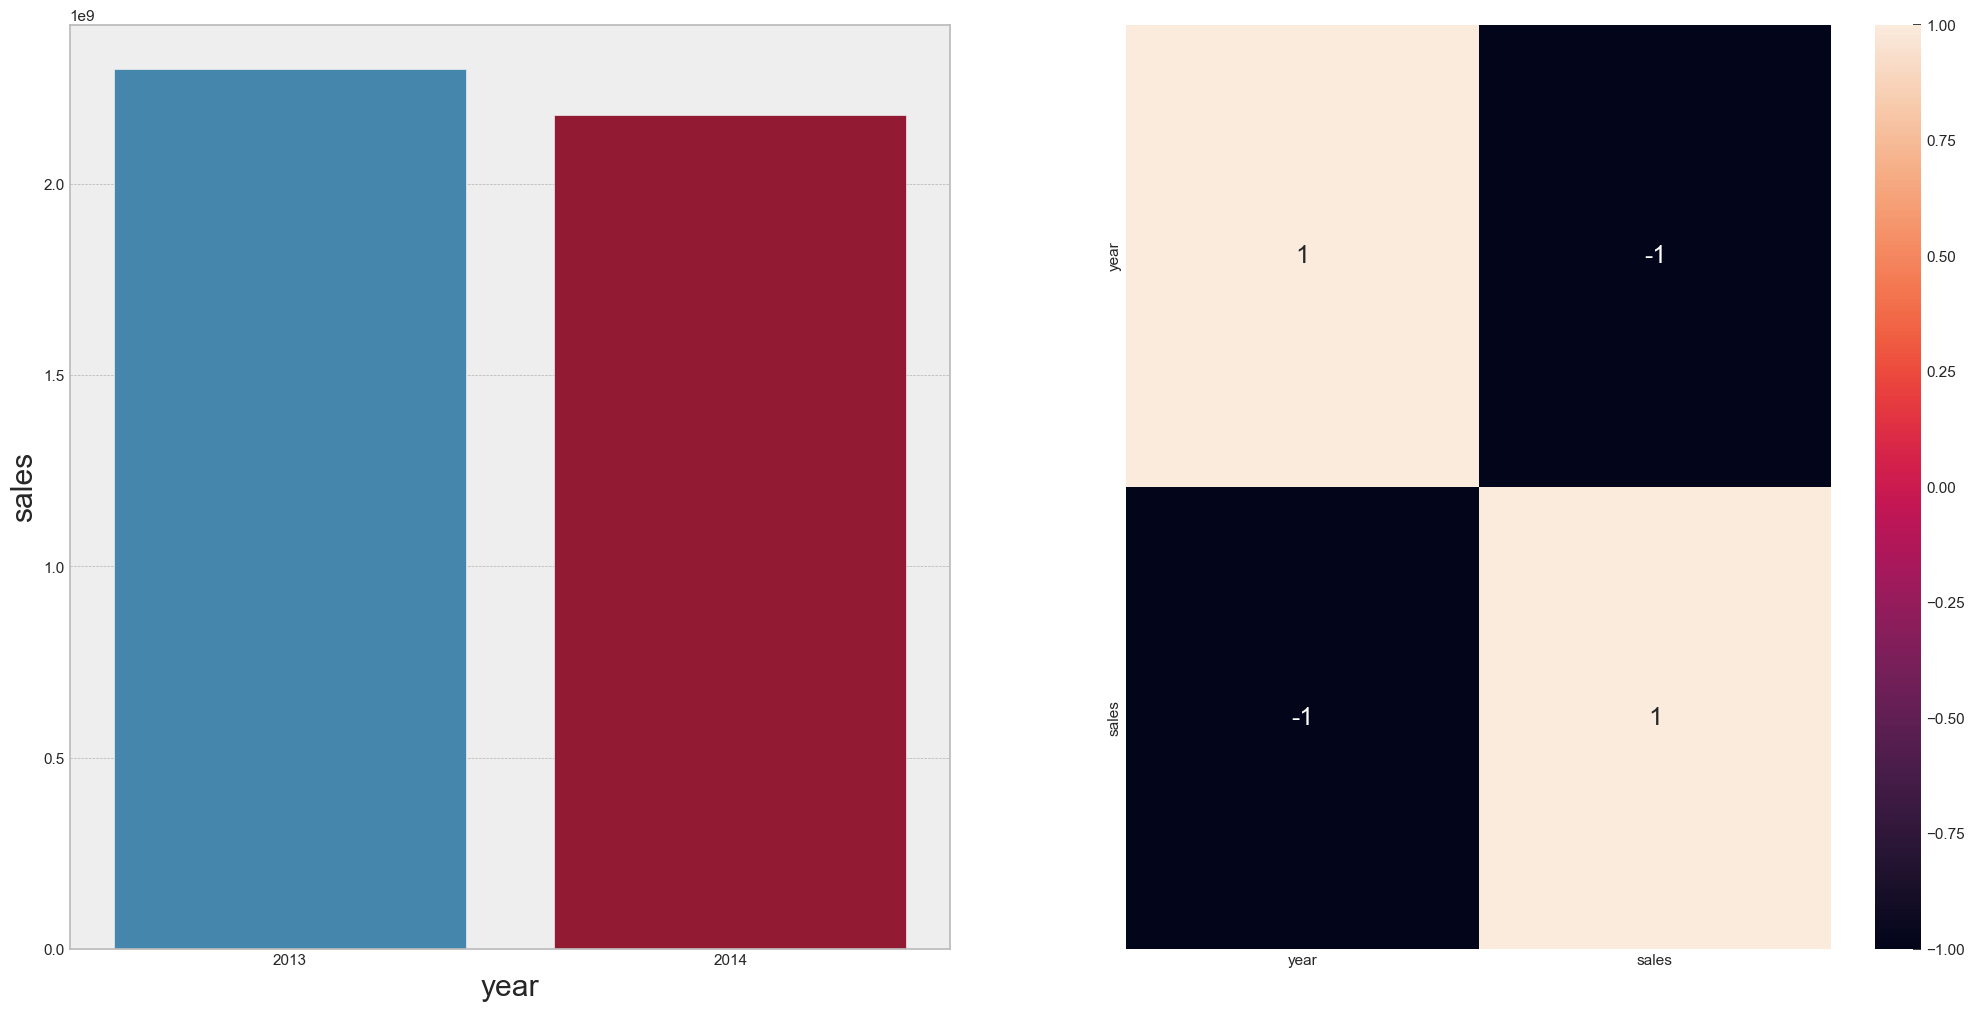

In [41]:
aux = df4[df4['year'] < 2015]
aux1= aux[['year','sales']].groupby('year').sum().reset_index()

plt.subplot(1,2,1)
sns.barplot(x= 'year',y='sales',data=aux1);
plt.subplot(1,2,2)
sns.heatmap(aux1.corr(method='pearson'),annot=True);


### H**10.** Lojas  deveriam vender mais no segundo semestre do ano
**FALSO** Lojas VENDEM MENOS no SEGUNDO SEMESTRE.

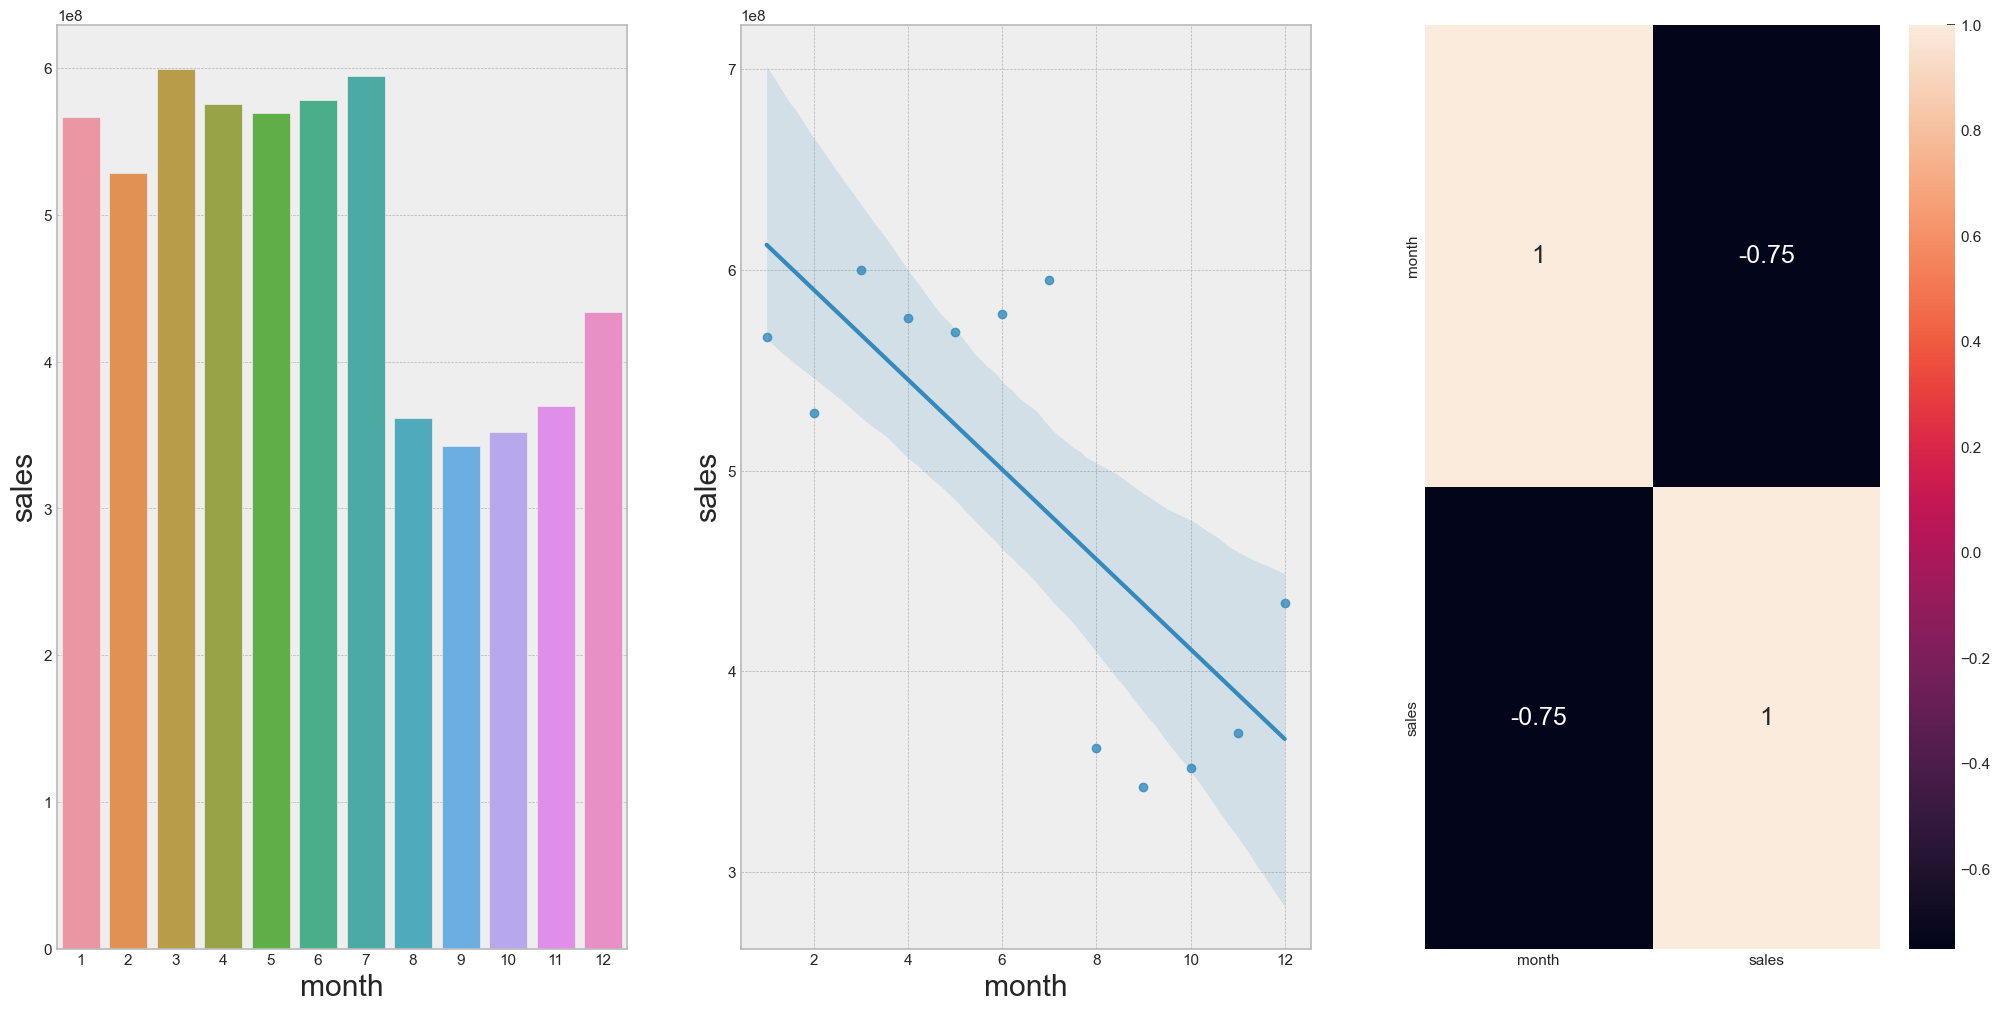

In [42]:
aux1= df4[['month','sales']].groupby('month').sum().reset_index();

plt.subplot(1,3,1)
sns.barplot(x= 'month', y= 'sales', data= aux1);

plt.subplot(1,3,2)
sns.regplot(x= 'month', y= 'sales', data= aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);


### H**11.** Lojas deveriam vender mais após o dia 10 de cada mes.
**VERDADEIRO** Lojas VENDEM MAIS APÒS o DIA 10 de cada mes.

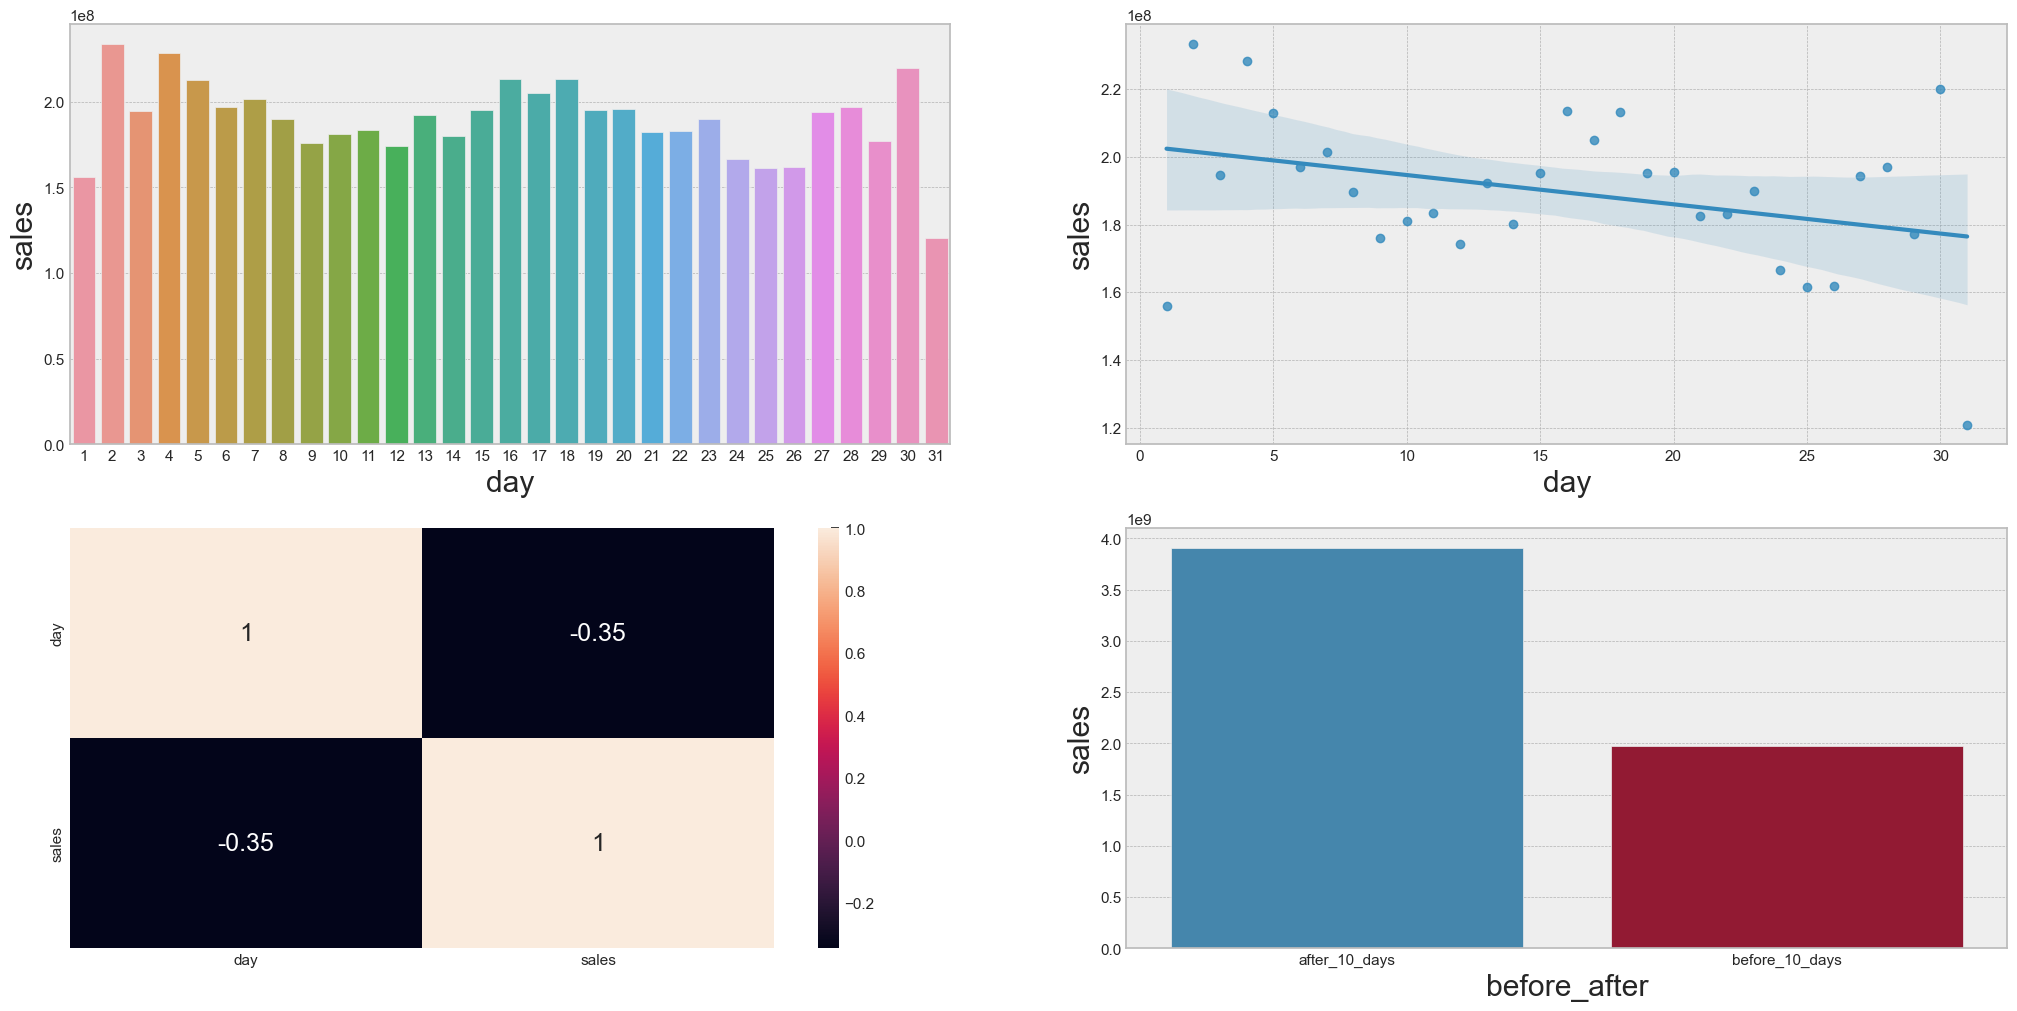

In [43]:
aux1= df4[['day','sales']].groupby('day').sum().reset_index();

plt.subplot(2,2,1)
sns.barplot(x= 'day', y= 'sales', data= aux1);

plt.subplot(2,2,2)
sns.regplot(x= 'day', y= 'sales', data= aux1);

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

aux1['before_after']= aux1['day'].apply(lambda x: 'before_10_days' if x <=10 else 'after_10_days')
aux2 = aux1[['before_after','sales']].groupby('before_after').sum().reset_index()

plt.subplot(2,2,4)
sns.barplot(x='before_after',y='sales',data=aux2);

### H**12.** Lojas deveriam vender menos nos finais de semana.
**VERDADEIRO**  Lojas VENDEM MENOS nos finais de semana.


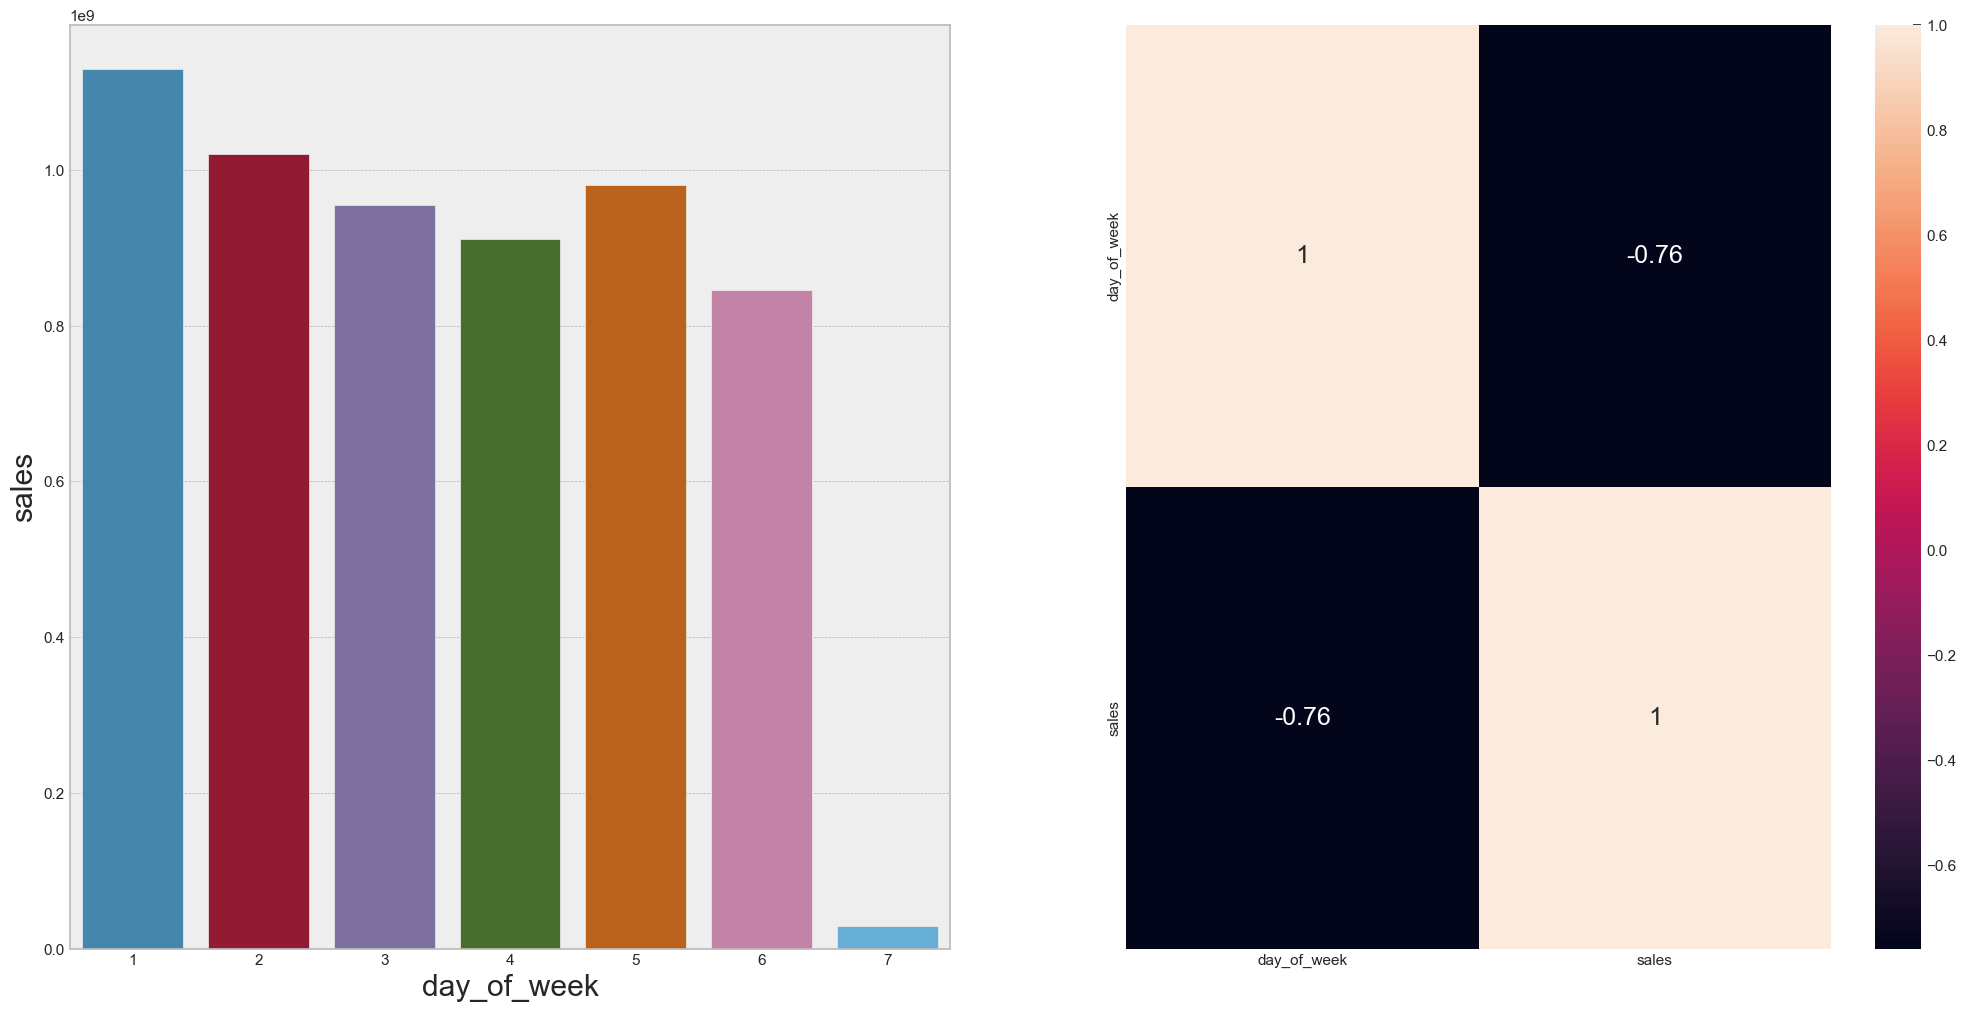

In [44]:
aux1= df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1,2,1)
sns.barplot(x= 'day_of_week',y='sales',data=aux1);

plt.subplot(1,2,2)
sns.heatmap(aux1.corr(method='pearson'),annot=True);


### H**13.** Lojas deveriam vender menos durante o feriado escolar
**VERDADEIRO** Lojas VENDEM MENOS durante o feriado escolar, EXCETO julho e Agosto

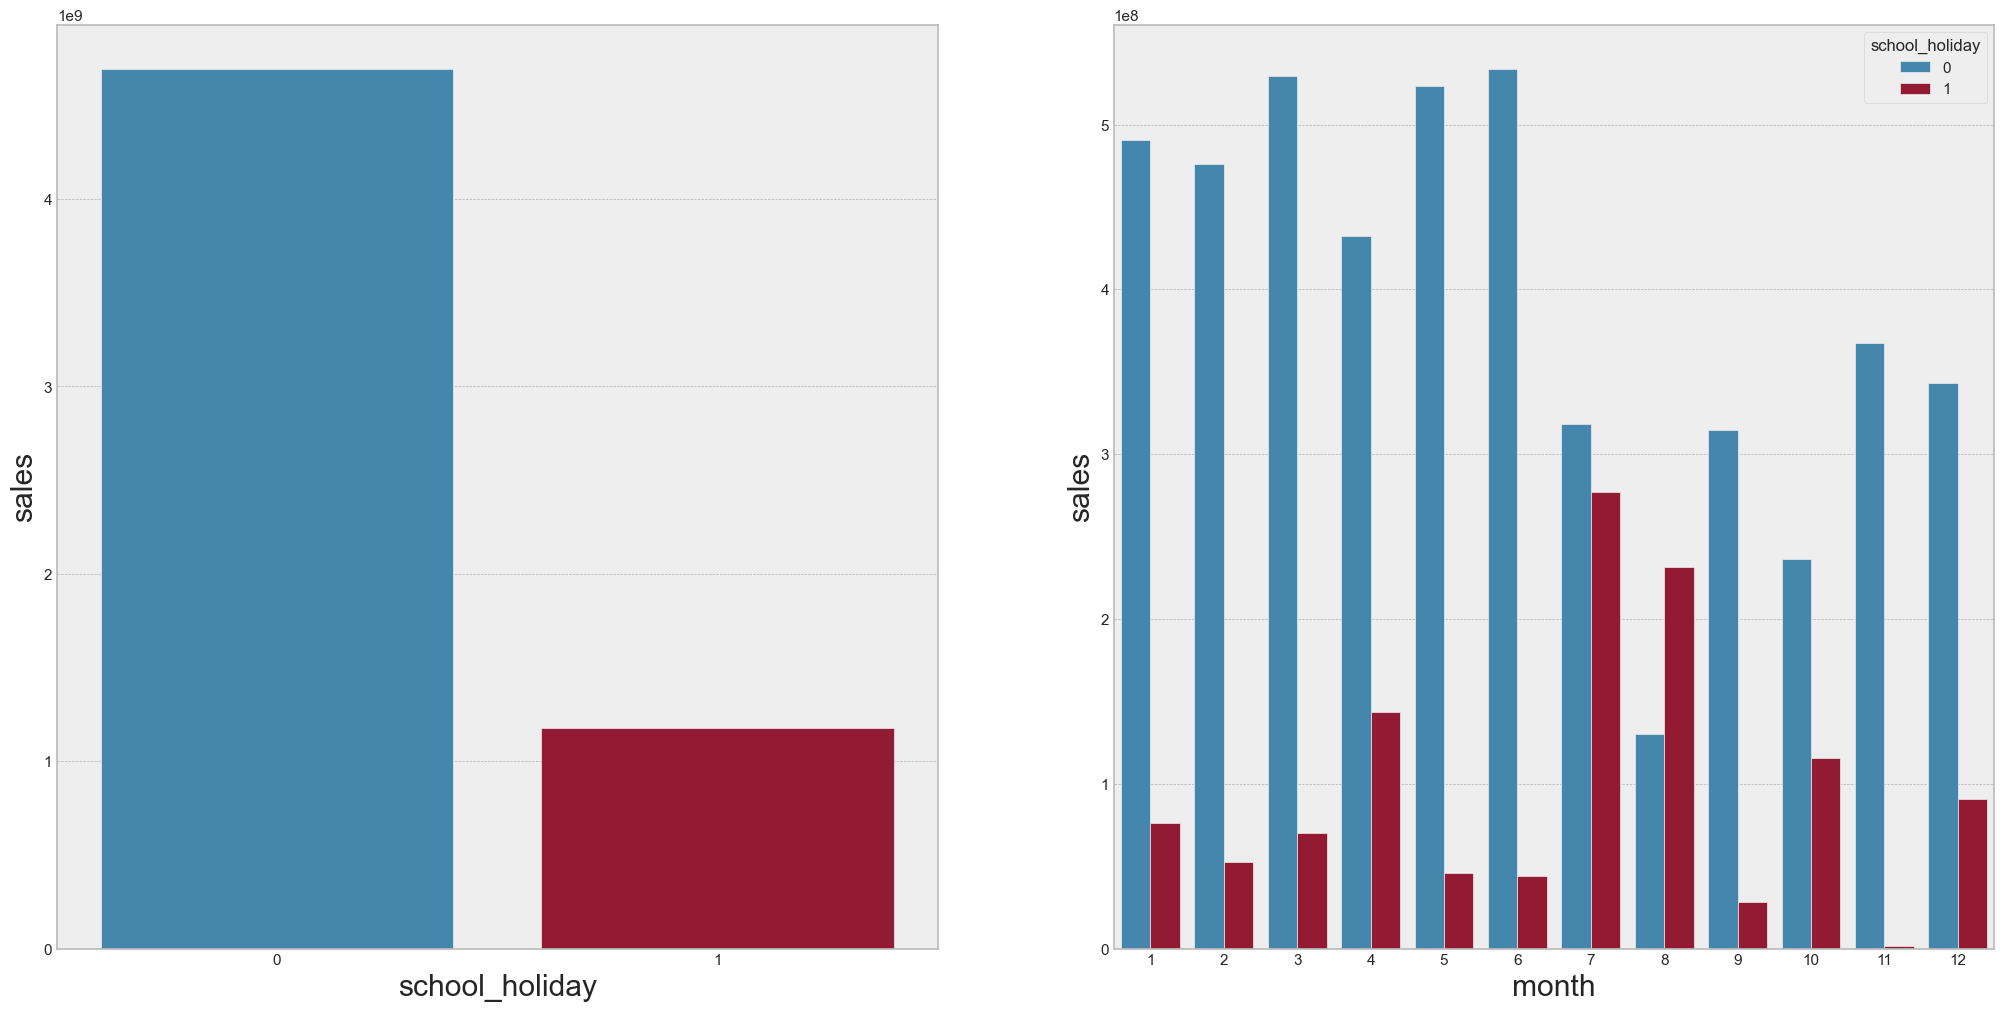

In [45]:
aux1=df4[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()

plt.subplot(1,2,1)
sns.barplot(x='school_holiday',y='sales',data=aux1);

plt.subplot(1,2,2)
aux2=df4[['month','school_holiday','sales']].groupby(['month','school_holiday']).sum().reset_index()
sns.barplot(x='month',y='sales',hue='school_holiday',data=aux2);

### RESUMO DAS HIPOTESES

In [46]:
tab = [['Hipoteses', 'Conclusão', 'Relevância Estimada'],
       ['H1', 'Falsa', 'Baixa'],
       ['H2', 'Falsa', 'Média'],
       ['H3', 'Falsa', 'Média'],
       ['H4', 'Falsa', 'Baixa'],
       ['H5', '-', '-'],
       ['H6', 'Falsa', 'Baixa'],
       ['H7', 'Falsa', 'Média'],
       ['H8', 'Falsa', 'Alta'],
       ['H9', 'Falsa', 'Alta'],
       ['H10', 'Falsa', 'Alta'],
       ['H11', 'Verdadeira', 'Alta'],
       ['H12', 'Verdadeira', 'Baixa']
      ]
print(tabulate(tab, headers='firstrow', stralign='center'))
#tablefmt='pipe', tablefmt='grid'

 Hipoteses    Conclusão    Relevância Estimada
-----------  -----------  ---------------------
    H1          Falsa             Baixa
    H2          Falsa             Média
    H3          Falsa             Média
    H4          Falsa             Baixa
    H5            -                 -
    H6          Falsa             Baixa
    H7          Falsa             Média
    H8          Falsa             Alta
    H9          Falsa             Alta
    H10         Falsa             Alta
    H11      Verdadeira           Alta
    H12      Verdadeira           Baixa


## 4.3 Multivariate Analysis

### 4.3.1 Numeric Attributes

<AxesSubplot:>

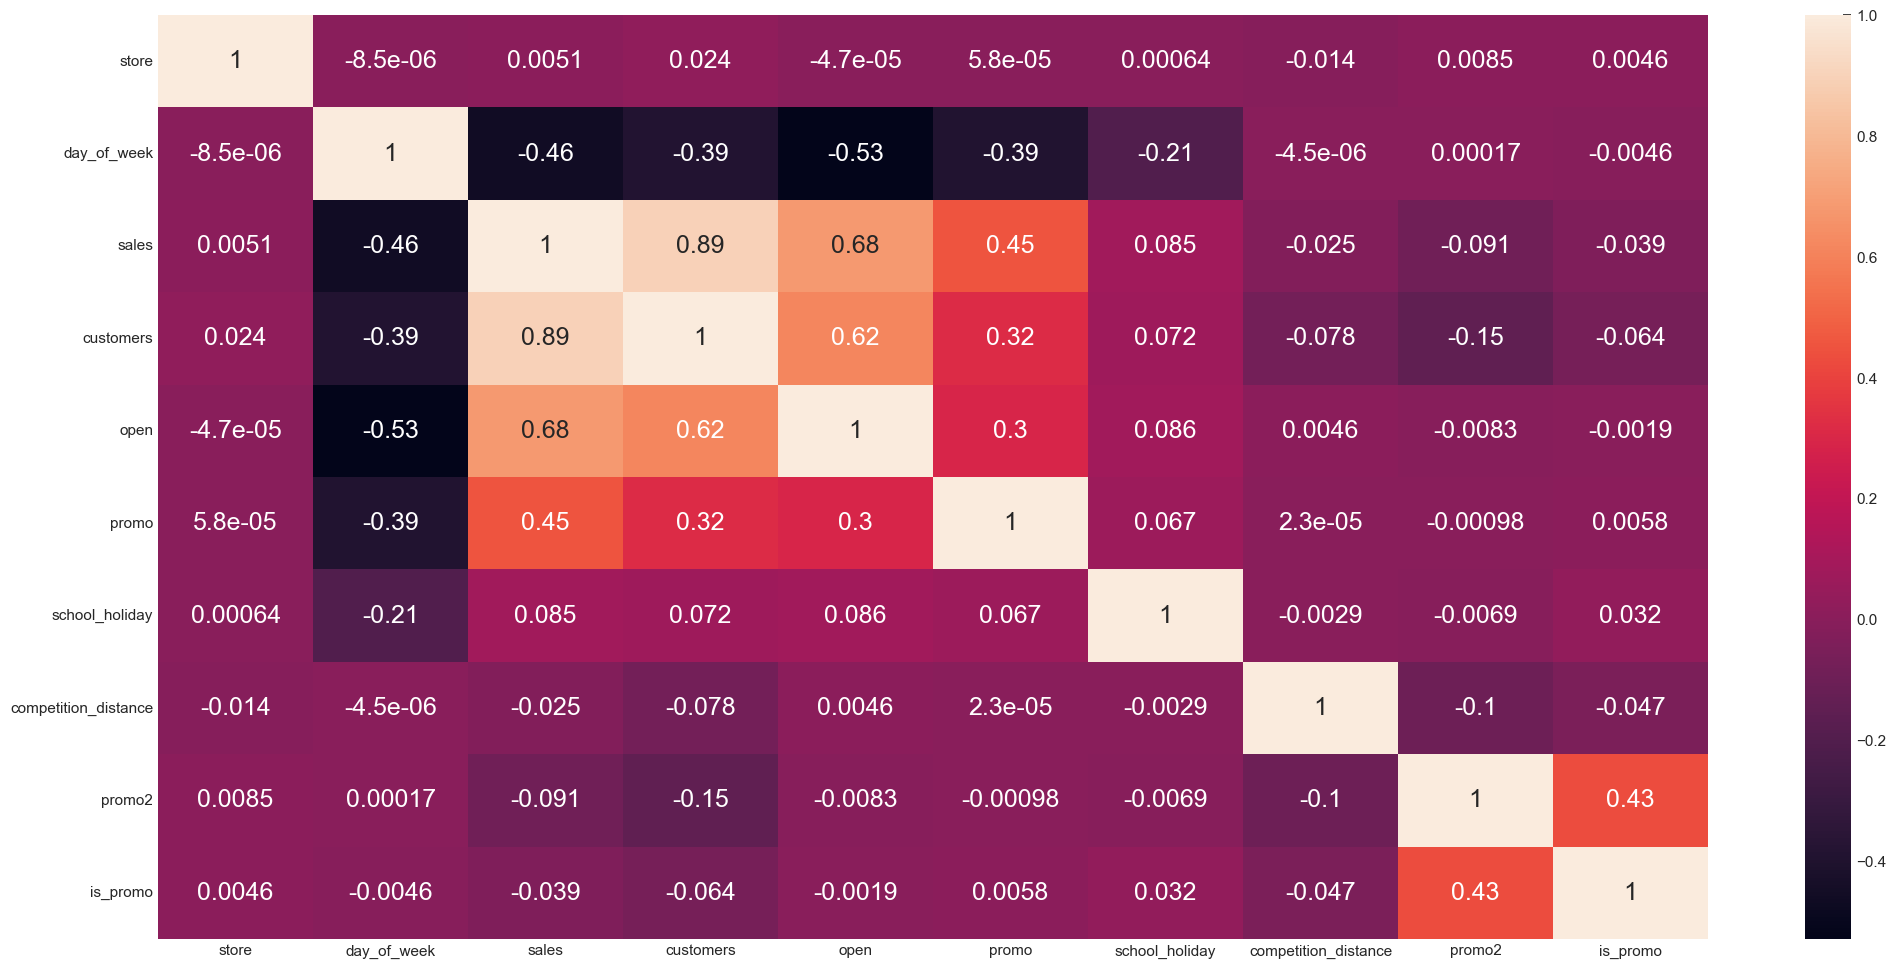

In [47]:
correlation= num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot= True)

### 4.3.2 Categorical Attributes

<AxesSubplot:>

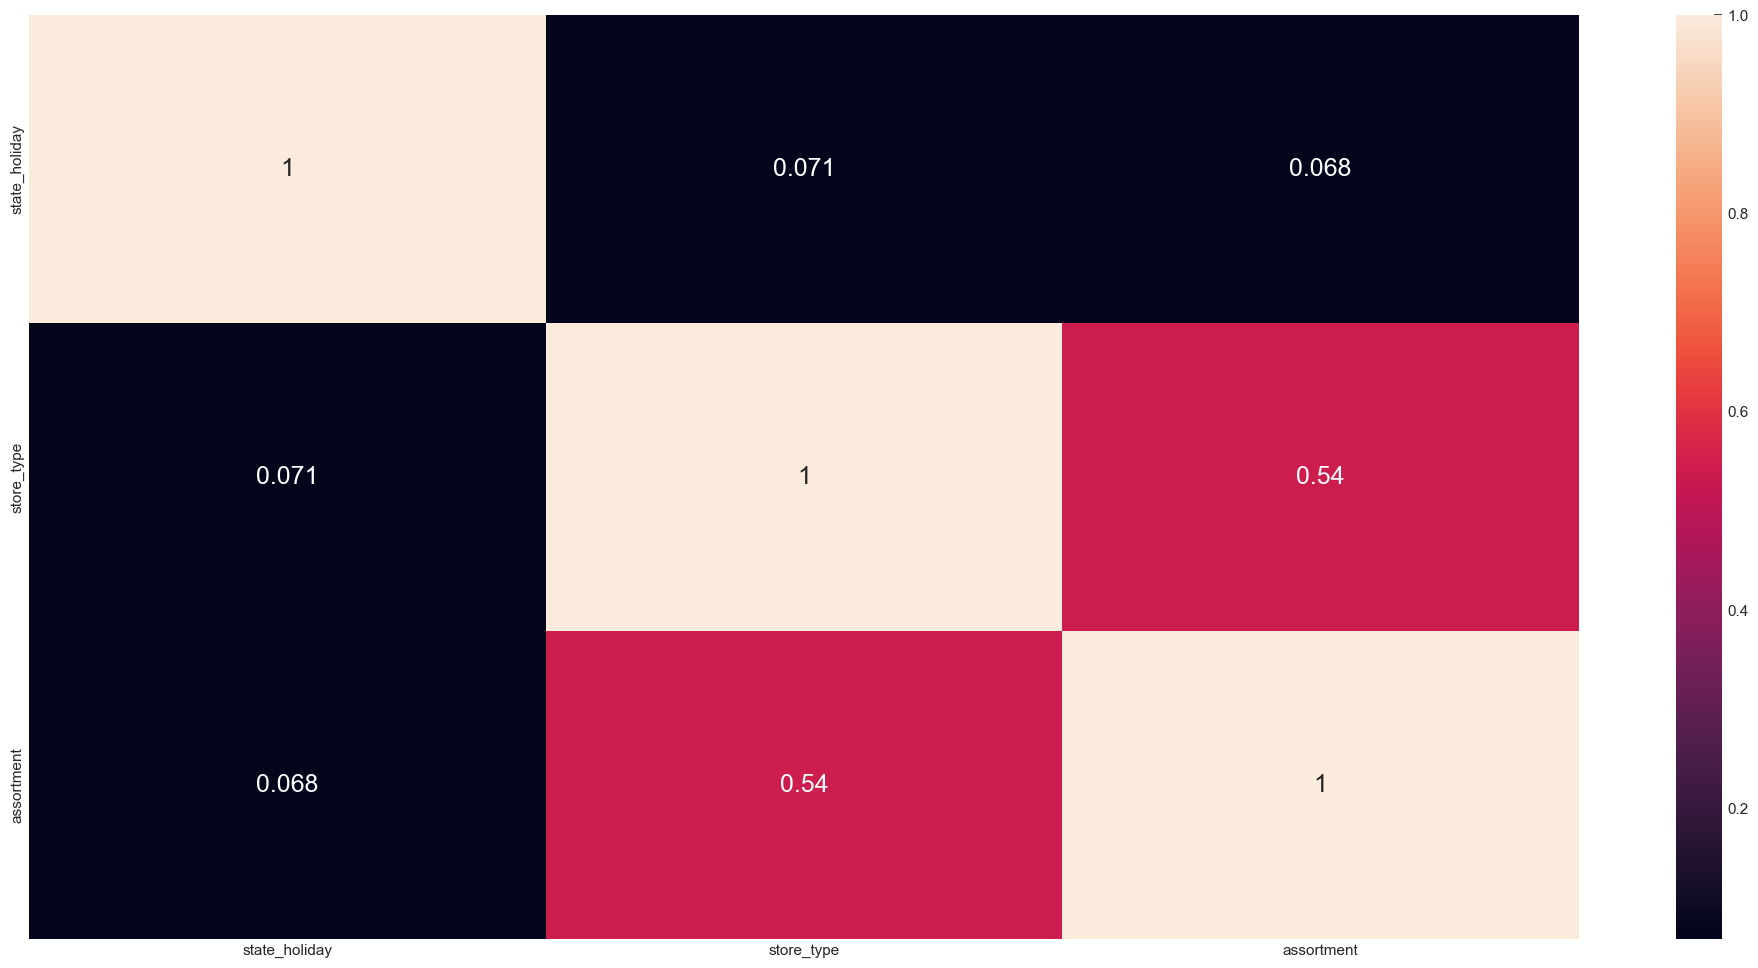

In [48]:
#only categorical data
a=df4.select_dtypes(include='object')

# calculate cramer
a1= cramer_v(a['state_holiday'],a['state_holiday'])
a2= cramer_v(a['state_holiday'],a['store_type'])
a3= cramer_v(a['state_holiday'],a['assortment'])

a4= cramer_v(a['store_type'],a['state_holiday'])
a5= cramer_v(a['store_type'],a['store_type'])
a6= cramer_v(a['store_type'],a['assortment'])

a7= cramer_v(a['assortment'],a['state_holiday'])
a8= cramer_v(a['assortment'],a['store_type'])
a9= cramer_v(a['assortment'],a['assortment'])

d=pd.DataFrame({'state_holiday': [a1,a2,a3],
             'store_type': [a4,a5,a6],
             'assortment': [a7,a8,a9]})

#Final dataset
d = d.set_index(d.columns)

sns.heatmap(d,annot=True)

# 5.0 Data Preparation

In [49]:
df5 = df4.copy()

## 5.1 Normalization

## 5.2 Rescaling

In [50]:
aux = df5.select_dtypes(include= ['int64','float64'])
aux.head(5)

,store,day_of_week,sales,promo,school_holiday,competition_distance,promo2,is_promo,year,month,day,week_of_year
0,1,5,5263,1,1,1270.0,0,0,2015,7,31,31
1,2,5,6064,1,1,570.0,1,1,2015,7,31,31
2,3,5,8314,1,1,14130.0,1,1,2015,7,31,31
3,4,5,13995,1,1,620.0,0,0,2015,7,31,31
4,5,5,4822,1,1,29910.0,0,0,2015,7,31,31


In [51]:
# Váriaveis Escolhidas(são continuas,não se repetem)
# competition_distance = distância em metros do consumidor mais próximo
# competition_time_month = há quantos meses a competição iniciou
# promo2_time_week = tempo em que a promoção ficou ativa em semanas
# year = é o ano da data de venda

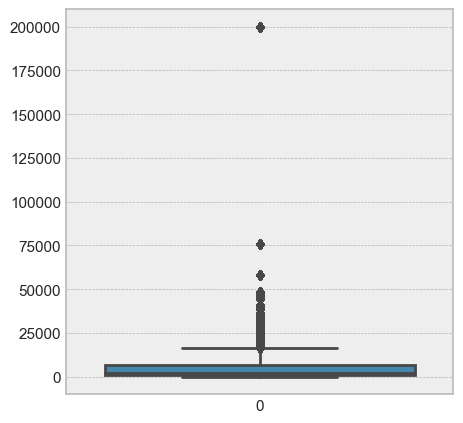

In [52]:
#definindo se a formula usada será min/max scaler ou robust scaler,a decisão é se tem outlier grande(usar robust) ou não(usar min/max).
plt.subplots(figsize= (5, 5))
sns.boxplot(df5['competition_distance']);

In [53]:
#instanciando Robust Scaller e Min Max Scaller:
rs = RobustScaler()
mms = MinMaxScaler()

#função fit_transform encontra os quartis 1 e 3 da coluna e aplica a formula ( Xi–Q2(x) ) / ( Q3(x) – Q1(x) ).

df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values) # 2 colchetes .values para pegar todos os valores da coluna
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)

#função fit_transform encontra os valores Maximo e minimo e aplica formula (x -xmin) / (xmax -xmin)
df5['year'] = mms.fit_transform(df5[['year']].values ) 
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)


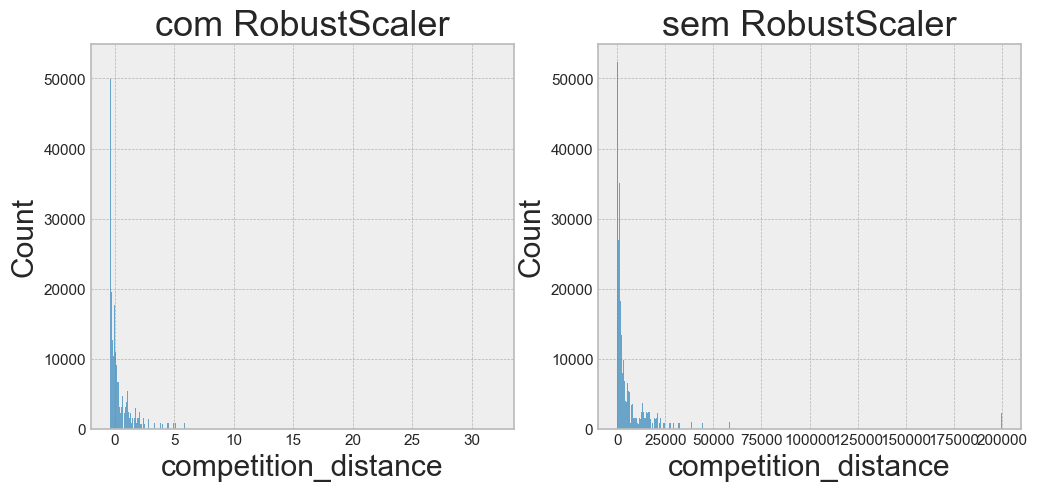

In [54]:
plt.subplots(figsize= (12, 5))

plt.subplot(1,2,1)
sns.histplot(df5['competition_distance']);
plt.title('com RobustScaler')

plt.subplot(1,2,2)
sns.histplot(df4['competition_distance']);
plt.title('sem RobustScaler');


## 5.3 Transformation

### 5.3.1 Enconding

In [55]:
# One Hot Encoding 
df5 = pd.get_dummies(df5,prefix=['state_holiday'],columns=['state_holiday'])

In [56]:
# Label Encoder
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

In [57]:
# Ordinal
dic = {'basic' : 1, 'extra': 2, 'extended': 3}
df5['assortment']=df5['assortment'].map(dic)

In [58]:
df5.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
promo                           0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
is_promo                        0
year                            0
month                           0
day                             0
week_of_year                    0
year_week                       0
competition_since               0
competition_time_month          0
promo_since                     0
promo_time_week                 0
state_holiday_christmas         0
state_holiday_easter_holiday    0
state_holiday_public_holiday    0
state_holiday_regular_day       0
dtype: int64

### 5.3.2 Response Variable Transformation 

In [59]:
df5['sales']= np.log1p(df5['sales'])

In [60]:
df5.head(5)

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1


### 5.3.3 Nature Transformation

In [61]:
# variaveis de natureza (são ciclicos, se repete)
# usar circulo trigonometrico, seno e cosseno.

df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * ( 2. * np.pi/12 ) ) )

df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi/12) ) )


df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * ( 2. * np.pi/7) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7) ) )


df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * ( 2. * np.pi/30) ) )
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi/30) ) )



df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * ( 2. * np.pi/48) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/48) ) )

# 6.0 Featuring Selection

In [62]:
df6 = df5.copy()

## 6.1 Split DataFrame in training and test dataset

In [63]:
# removendo variaveis colineares
cols_drop = ['week_of_year','day','day_of_week','month','promo_since','competition_since','year_week']
df6 = df6.drop(cols_drop,axis=1)

In [64]:
#separando o conjunto para treino. data inicial até as ultimas 6 semanas.
#descobrindo a data antes das ultimas 6 semanas.
df6[['store','date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7)

X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales'] 

X_test = df6[df6['date'] >= '2015-06-19' ]
y_test = X_test['sales'] 

print('Training Min Date {}'.format( X_train['date'].min()))
print('Training Max Date {}'.format( X_train['date'].max()))

print('\nTesting Min Date {}'.format( X_test['date'].min()))
print('Testing Max Date {}'.format( X_test['date'].max()))

Training Min Date 2013-01-01 00:00:00
Training Max Date 2015-06-18 00:00:00

Testing Min Date 2015-06-19 00:00:00
Testing Max Date 2015-07-31 00:00:00


## 6.2 Boruta as feature select

In [65]:
# training and test dataset for Boruta
x_train_n = X_train.drop(['date','sales'],axis=1).values #.values pega só os valores do dataframe
y_train_n = y_train.values.ravel()#.ravel coloca tudo em um vetor

# define Random ForestRegressor
rf=RandomForestRegressor(n_jobs=-1)# usar todos os cores da maquina e crie as arvores em paralelo

# a classe boruta recebe como 1°argumento o modelo,no caso o Random Forest,2°estimativa de arvores para ramificação,3°ver a plotagem,
# 4°pode ser qualquer numero para q parta do mesmo inicio/aleatoriedade. Para rodar usa metodo fit e passa os parametros q n pode ser data frame,
# tem que ser um matriz/vetor (usar numpy)
#boruta= BorutaPy(rf,n_estimators='auto',verbose=2,random_state = 42).fit(x_train_n,y_train_n)


In [66]:
# msg q o boruta descreve
#Iteration: Interação
#Confirmed: qts variaveis relevantes
#Tentative: qts teve duvidas 
#Rejected: qts não são relevantes

### 6.2.1 Best Features from Boruta

In [67]:
#retorna True ou False pra cada coluna relevante ou nao
#cols_selected = boruta.support_.tolist()

# como o x_train virou vetor, precisamos dele como dataframe
x_train_fs = X_train.drop(['date','sales'],axis=1)


# colunas q o Boruta selecionou.
#iloc para ver os index, já q não tem mais os nomes.
# p/ n devolver um dataframe usa .columns para pegar só os nomes e .to_list melhora a view
#cols_selected_boruta = x_train_fs.iloc[:,cols_selected].columns.to_list()

# retorna as colunas que o Boruta não selecionou. usa list para melhorar view.
#cols_not_selected_boruta= list(np.setdiff1d(x_train_fs.columns,cols_selected_boruta))



## 6.3 Manual Feature Selection

In [69]:
# copiando as features escolhidas p/ dataset, assim n será preciso rodar o boruta.
cols_selected_boruta = ['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'month_cos',
 'month_sin',   #added manually             
 'day_of_week_sin', #added manually
 'day_of_week_cos',
 'day_sin', #added manually
 'day_cos']

In [79]:
## add date para separar os conjunto de dados e o sales é a variavel resposta/fenomeno para treinar os algoritmos.
feat_to_add = ['date','sales']

#add columns date and sales for cross validation in step 7.6
cols_selectted_boruta_full = cols_selected_boruta.copy()
cols_selectted_boruta_full.extend(feat_to_add) #metodo extend add os elementos da 'feat_to_add' no final da lista cols_selected_boruta. 
################################# comentar ao treinar o modelo e descomentar para cross validation

In [ ]:
#  colunas que o Boruta não selecionou.
#cols_not_selected_boruta

# 7.0 Machine Learning Modeling

In [70]:
x_train = X_train[cols_selected_boruta]  # x minusculos só as variaveis relevantes                
x_test = X_test[cols_selected_boruta]

In [80]:
# add as features para treino, x_trainning c/ x minusculo é todas as variaveis relevantes com date e sales incluso.
# n esquecer de fazer a separação quando fazer cross validation
x_training= X_train[cols_selectted_boruta_full ]     ################################# comentar ao treinar o modelo

## 7.1 Average Model

In [71]:
aux1 = X_test.copy()
aux1['sales'] = y_test.copy()

#prediction
aux2 = aux1[['store','sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})

#anexando nos dados originais do boruta
aux1= pd.merge(aux1,aux2,how='left',on='store')

#yhat na matematica é td q é estimado/predito.
yhat_baseline =aux1['predictions']

#calcular a predição das medias performance
#No 5.3.2 a variavel 'sales' foi treinada com log, e p/fazer a analise de performance, precisamos voltar ao valor original, usando exponencial. 
#criando a função de calcular
baseline_result= ml_error ('Average Model',np.expm1(y_test),np.expm1(yhat_baseline))
baseline_result

,Model Name,Mae,Mape,RMSE
0,Average Model,1354.800353,0.2064,1835.135542


## 7.2 Linear Regression Model

In [73]:


#model
lr= LinearRegression().fit(x_train,y_train)

#prediction
yhat_lr =lr.predict(x_test)

lr_result = ml_error('Linear Regression',np.expm1(y_test),np.expm1(yhat_lr))
lr_result

,Model Name,Mae,Mape,RMSE
0,Linear Regression,1868.255048,0.292406,2674.402343


### 7.2.1 Linear Regression Model - Cross Validation

In [81]:
#o 1° parametro são as features de treino,2° qtd de 'fatias',3°nomde do modelo ml,4° instancia q armazena a função do modelo,5° ver rodando
lr_result_cv=cross_validation(x_training, 2,'Linear Regression',lr,verbose = False)
lr_result_cv

## 7.3 Linear Regression Regularized Model- LASSO

In [74]:
#model Lasso(alpha=0.01) fator multiplicativo q cada peso p/q fique dentro de um range para q n "estourem", e tenham a mesma relevancia.
lrr= Lasso(alpha=0.001).fit(x_train,y_train)

#prediction
yhat_lrr =lrr.predict(x_test)

lrr_result = ml_error('Linear Regression - Lasso',np.expm1(y_test),np.expm1(yhat_lrr))
lrr_result

,Model Name,Mae,Mape,RMSE
0,Linear Regression - Lasso,1869.571858,0.288111,2694.005137


- Percebemos que o Fenomeno é COMPLEXO, pq ele não é Linear, já que o modelo RMSE é menor que o result da media.

### 7.3.1 Lasso - Cross Validation

In [83]:
lrr_result_cv = cross_validation(x_training, 2,'Lasso',lrr,verbose = False)
lrr_result_cv

## 7.4 Random Forest Regressor

In [77]:
# model
rf = RandomForestRegressor(n_estimators=100,n_jobs=-1,random_state=42).fit(x_train,y_train)

#predict
yhat_rf = rf.predict(x_test)

#performance
rf_result = ml_error('Random Forest Regressor',np.expm1(y_test),np.expm1(yhat_rf))
rf_result

,Model Name,Mae,Mape,RMSE
0,Random Forest Regressor,705.15909,0.105053,1036.355309


### 7.4.1 Random Forest Regressor - Cross Validation

In [85]:
rf_result_cv = cross_validation(x_training, 2,'Random Forest Regressor',rf,verbose = True)
rf_result_cv


KFold Number: 2

KFold Number: 1


,MAE_CV,MAPE_CV,RMSE_CV
0,771.77 +/- 72.48,0.1 +/- 0.0,1144.84 +/- 136.98


## 7.5 XGBoost Regressor

In [76]:
# model
model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                            n_estimators=100,
                            eta=0.01, # qts passadas usa p/aprendizado
                            max_depth=10, #max ramificação q arvore pode chegar
                            subsample=0.7, #porc de amostra das variaveis
                            colsample_bytree=0.9).fit(x_train,y_train) #combinações das varias arvores
                        

#predict
yhat_xgb = model_xgb.predict(x_test)

#performance
xgb_result = ml_error('XGBoost Regressor',np.expm1(y_test),np.expm1(yhat_xgb))
xgb_result

,Model Name,Mae,Mape,RMSE
0,XGBoost Regressor,6682.758874,0.949339,7330.080506


### 7.5.1 XGBoost Regressor - Cross Validation

In [86]:
xgb_result_cv = cross_validation(x_training, 2,'XGBoost Regressor',model_xgb,verbose = True)
xgb_result_cv


KFold Number: 2

KFold Number: 1


,MAE_CV,MAPE_CV,RMSE_CV
0,7113.71 +/- 125.62,0.95 +/- 0.0,7780.99 +/- 173.46


## 7.6 Compare Model's Performance

### 7.6.1 Single Performance

In [78]:
modelling_result=pd.concat([baseline_result,lr_result,lrr_result,rf_result,xgb_result])
modelling_result.sort_values('RMSE')

,Model Name,Mae,Mape,RMSE
0,Random Forest Regressor,705.159090,0.105053,1036.355309
0,Average Model,1354.800353,0.206400,1835.135542
0,Linear Regression,1868.255048,0.292406,2674.402343
0,Linear Regression - Lasso,1869.571858,0.288111,2694.005137
0,XGBoost Regressor,6682.758874,0.949339,7330.080506


### 7.6.2 Real Performance

In [87]:
modelling_result_cv =pd.concat([lr_result_cv,lrr_result_cv,rf_result_cv,xgb_result_cv])
modelling_result.sort_values('RMSE')

,Model Name,Mae,Mape,RMSE
0,Random Forest Regressor,705.159090,0.105053,1036.355309
0,Average Model,1354.800353,0.206400,1835.135542
0,Linear Regression,1868.255048,0.292406,2674.402343
0,Linear Regression - Lasso,1869.571858,0.288111,2694.005137
0,XGBoost Regressor,6682.758874,0.949339,7330.080506


In [ ]:
# possui todos os dados relevantes mas n possue o date e sales, add no passo 6.3 para iniciar o cross validation
x_train.head()

# 8.0 Hyperparameter Fine Tuning

## 8.1. Random Search

In [88]:
param = {'n_estimators': [15,25,30],
        'eta': [0.01,0.05],
        'max_depth': [3,5,9],
        'subsample': [0.1,0.5,0.9],
        'colsample_bytree': [0.03,0.04,0.06,0.07],
        'min_child_weight': [2,3,10]}

#mostra quantas iterações vai ter(quantas vezes vai rodar, )
max_eval = 2

In [92]:
import random
final_result = pd.DataFrame()

for i in range ( max_eval ):
    # choose values for parameters randomly
    hp = { k: random.sample(v,1)[0] for k, v in param.items() } # quando usa items() ele pega só o primeiro valor precisa usar FOR 
    print( hp ) 
    
    #model
    model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror', #função objetiva
            n_estimators = hp['n_estimators'], #quantas árvores vai criar (fica legal com umas 3k arvores: leva horas)
            eta = hp['eta'], #quantas passadas usa pra fazer o aprendizado
            max_depth = hp['max_depth'], #máxima ramificação da árvore
            subsample = hp['subsample'], #% das variáveis de amostra pra selecionar as relevantes
            colsample_bytree = hp['colsample_bytree'],
            min_child_weight = hp['min_child_weight'] )

    #performance:
                                        #kfold é 5, 2 pra teste!!
    result = cross_validation( x_training, 2 , 'XGBoost Regressor', model_xgb, verbose=False)
    final_result = pd.concat( [final_result, result] )
    
final_result    

{'n_estimators': 30, 'eta': 0.05, 'max_depth': 3, 'subsample': 0.9, 'colsample_bytree': 0.06, 'min_child_weight': 10}
{'n_estimators': 15, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytree': 0.06, 'min_child_weight': 10}


,MAE_CV,MAPE_CV,RMSE_CV
0,6349.59 +/- 128.9,0.83 +/- 0.0,7095.26 +/- 180.38
0,7421.3 +/- 128.3,1.0 +/- 0.0,8075.4 +/- 175.39


## 8.2.Final Model

In [93]:
param_tuned = {'n_estimators': 15,
        'eta': 0.01,
        'max_depth': 5,
        'subsample': 0.5,
        'colsample_bytree':0.06,
        'min_child_weight': 10}

#mostra quantas iterações vai ter
max_eval = 2

In [94]:
# O Ml_error só testa a performance , n treina o modelo e precisamos treinar agota com .fit
# model
model_xgb_tuned = xgb.XGBRegressor(objective='reg:squarederror',
                                n_estimators=param_tuned['n_estimators'],
                                eta=param_tuned['eta'], # qts passadas usa p/aprendizado
                                max_depth=param_tuned['max_depth'], #max ramificação q arvore pode chegar
                                subsample=param_tuned['subsample'], #porc de amostra das variaveis
                                colsample_bytree=param_tuned['colsample_bytree'], #combinações das varias arvores
                                min_child_weight=param_tuned['min_child_weight']).fit(x_train,y_train,)

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

#performance
xgb_result_tuned = ml_error('XGBoost Regressor',np.expm1(y_test),np.expm1(yhat_xgb_tuned))
xgb_result_tuned    

,Model Name,Mae,Mape,RMSE
0,XGBoost Regressor,6990.926572,0.99928,7624.89515


In [ ]:
import pickle # armazena objetos seriais 0 e 1

In [ ]:
pickle.dump(xgb_result_tuned,open(C:\Users\wesle\source\repos\projetos_ds\rossman))